1. Sinyal MIT-BIH:
Direkam pada frekuensi sampling 125 Hz dengan durasi panjang untuk setiap sesi.
Menggambarkan kondisi pasien dengan aritmia seperti PVC (Premature Ventricular Contractions), Bigeminy, dan lainnya.

2. Sinyal PTBDB:
Juga direkam pada frekuensi sampling 125 Hz.

  Dataset ini mengelompokkan sinyal menjadi Normal dan Abnormal, termasuk gangguan seperti iskemia dan infark miokard.
  Dataset tersebut menyediakan label yang mengindikasikan jenis sinyal, antaralain :
   - MIT-BIH: Kelas ['N' (Normal), 'S', 'V', 'F', 'Q']
   - PTBDB: Kategori 0 (Normal) dan 1 (Abnormal)

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
files = {
    'MIT-BIH Test': '/content/mitbih_test.csv',
    'MIT-BIH Train': '/content/mitbih_train.csv',
    'PTBDB Abnormal': '/content/ptbdb_abnormal.csv',
    'PTBDB Normal': '/content/ptbdb_normal.csv'
}

datasets = {title: pd.read_csv(file, header=None) for title, file in files.items()}


## Pre-processing dataset

In [84]:
def clean_data(data):
    if 'ALIGNED' in data.columns:
        data = data.drop(columns=['ALIGNED'])
        data = data.apply(pd.to_numeric, errors='coerce')
        data = data.dropna(how='all')
        data = data.dropna(axis=1, how='all')
        data = data.drop_duplicates()
    return data


cleaned_datasets = {title: clean_data(data) for title, data in datasets.items() if data is not None}


for title, data in cleaned_datasets.items():
    print(f"{title} Cleaned Data:")
    print(data.info())

MIT-BIH Test Cleaned Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
None
MIT-BIH Train Cleaned Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None
PTBDB Abnormal Cleaned Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 15.1 MB
None
PTBDB Normal Cleaned Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 5.8 MB
None


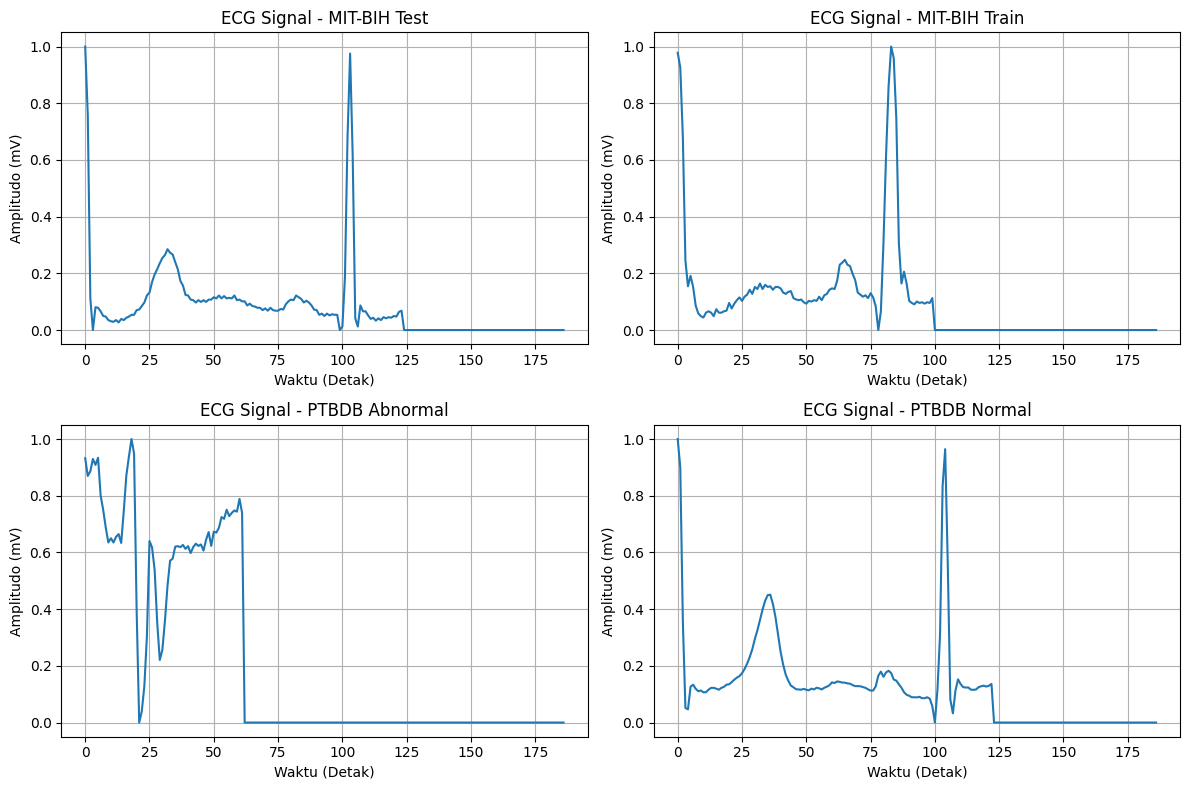

In [85]:
plt.figure(figsize=(12, 8))
for i, (title, data) in enumerate(datasets.items()):
    if data is not None and not data.empty:
        ecg_signal = data.iloc[0, :-1] if data.shape[1] > 1 else data.iloc[0, :]
        plt.subplot(2, 2, i + 1)
        plt.plot(ecg_signal)
        plt.title(f"ECG Signal - {title}")
        plt.xlabel("Waktu (Detak)")
        plt.ylabel("Amplitudo (mV)")
        plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
!pip install mplcursors

## Visualisasi Sinyal

## a. Domain Waktu

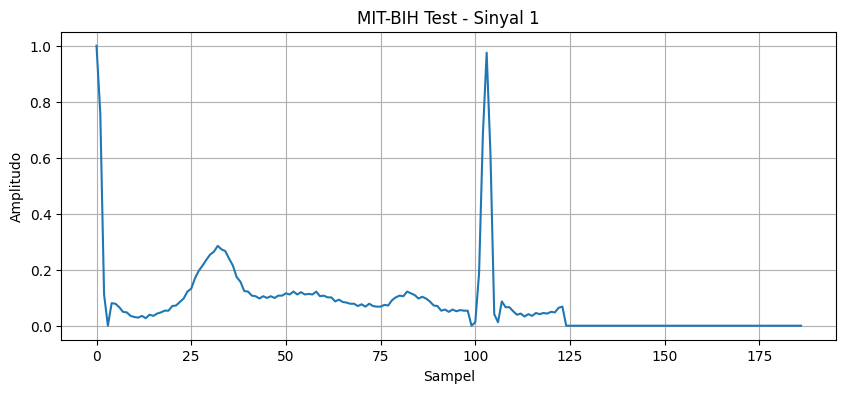

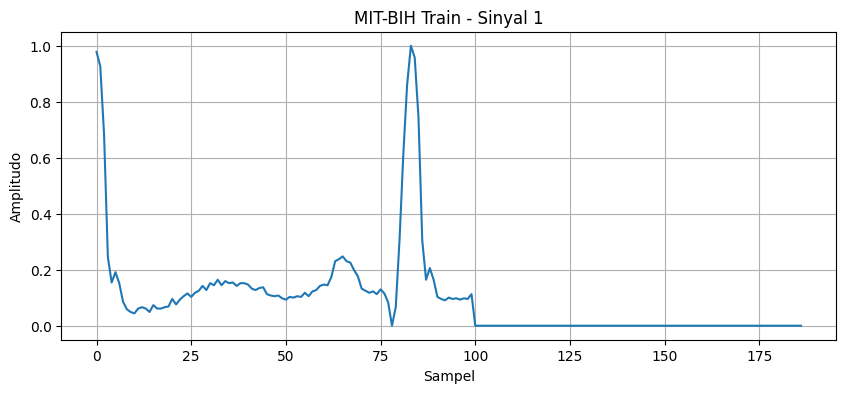

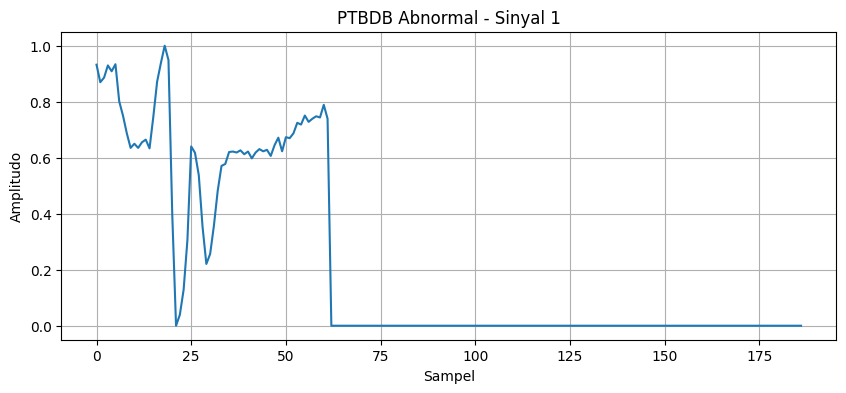

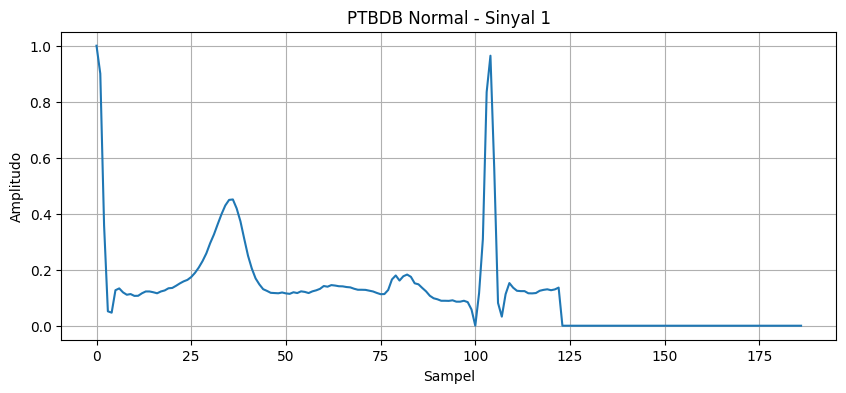

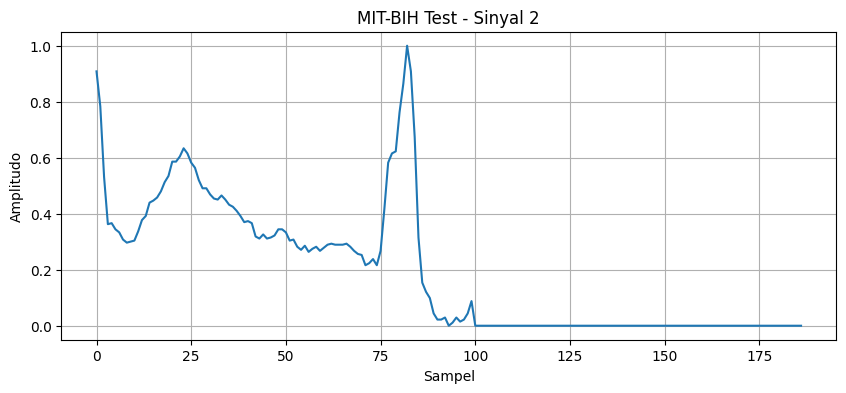

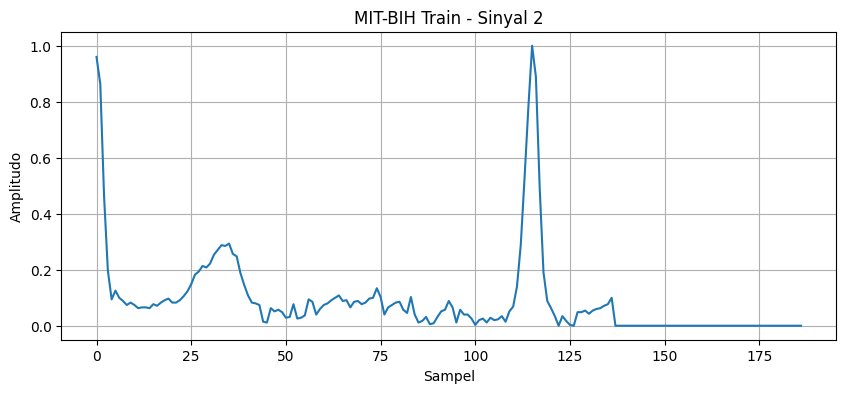

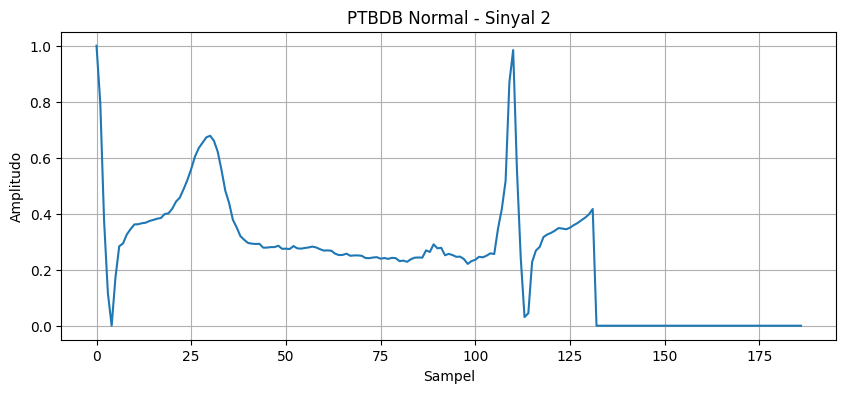

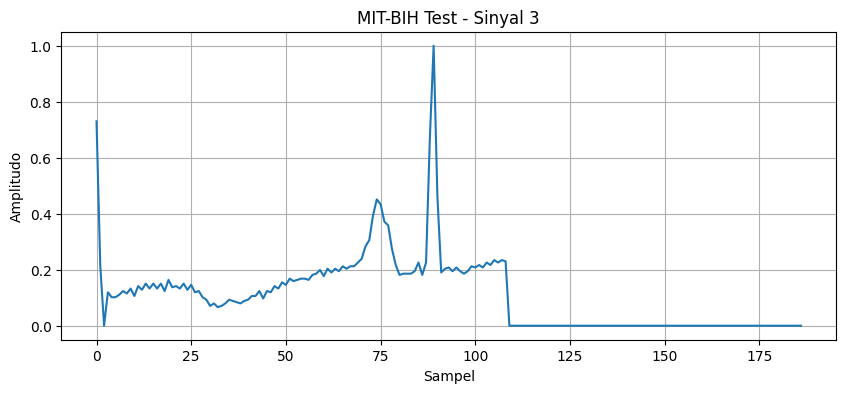

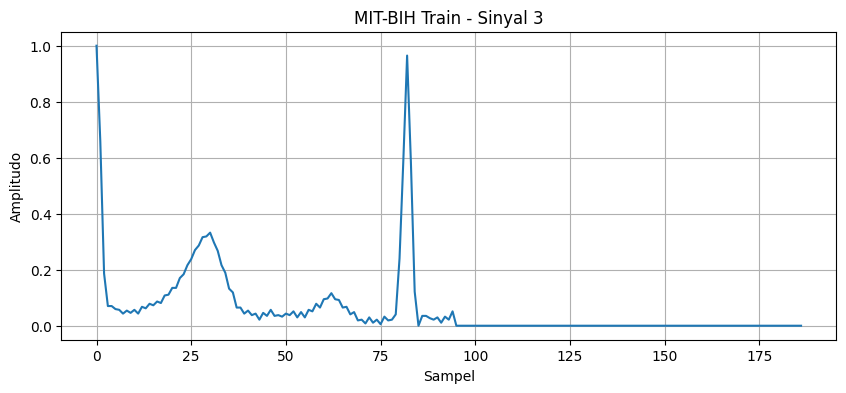

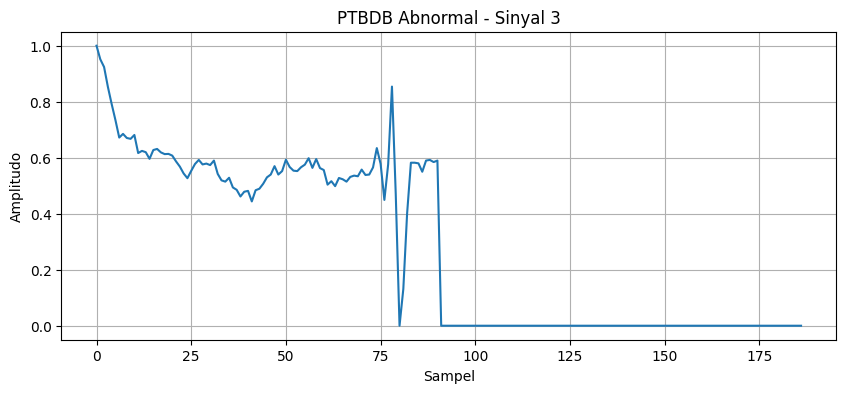

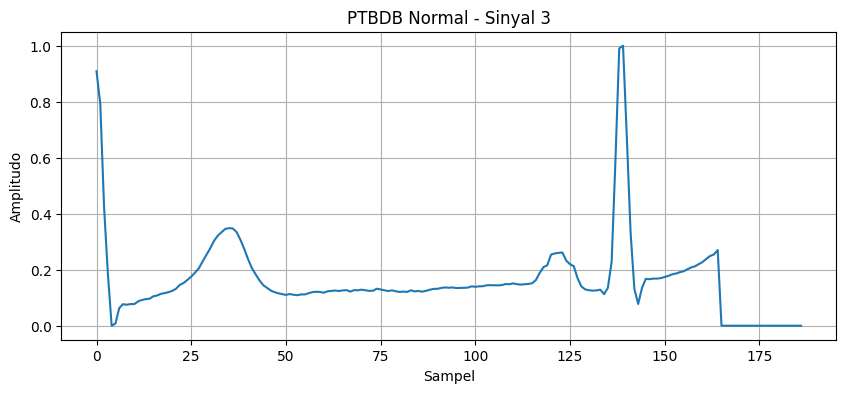

In [86]:
def plot_ecg_signal(data, title, signal_index):
    if data is not None and not data.empty:
        plt.figure(figsize=(10, 4))
        ecg_signal = data.iloc[signal_index, :-1] if data.shape[1] > 1 else data.iloc[signal_index, :]
        plt.plot(ecg_signal)
        plt.title(f'{title} - Sinyal {signal_index + 1}')
        plt.xlabel('Sampel')
        plt.ylabel('Amplitudo')
        plt.grid()
        plt.show()

for i in range(3):
    for title, data in datasets.items():
        plot_ecg_signal(data, title, i)


## b. Domain Frekuensi

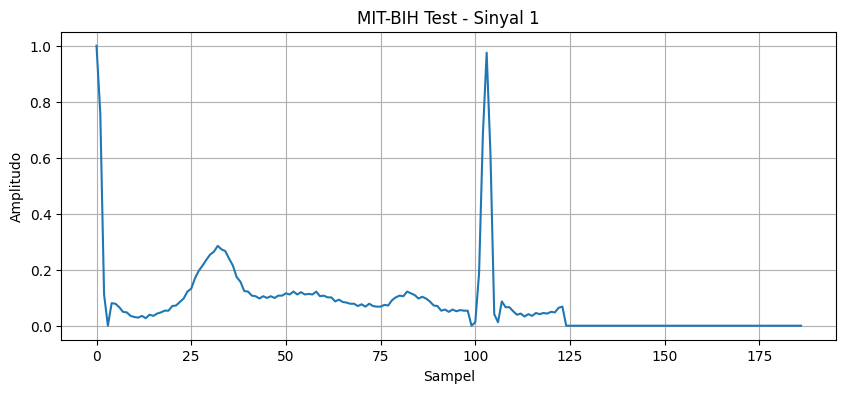

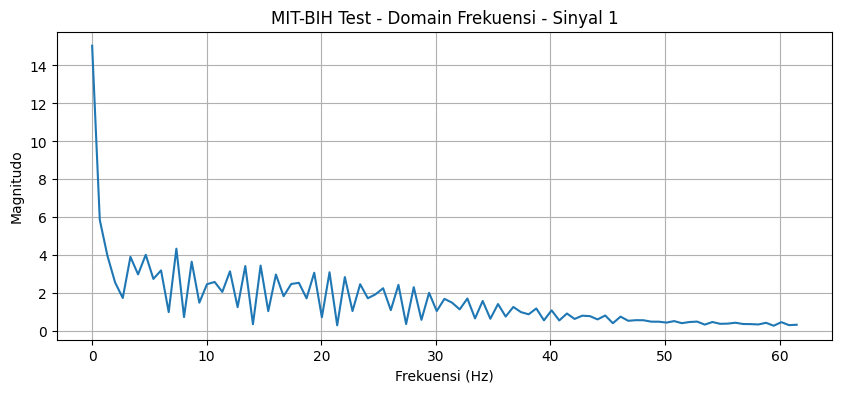

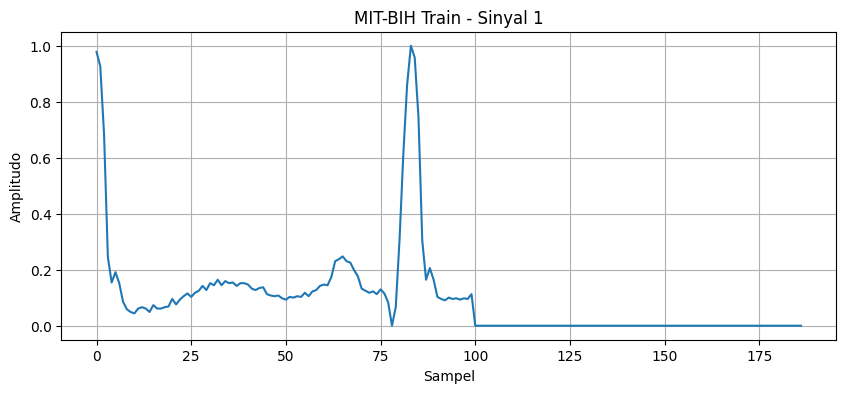

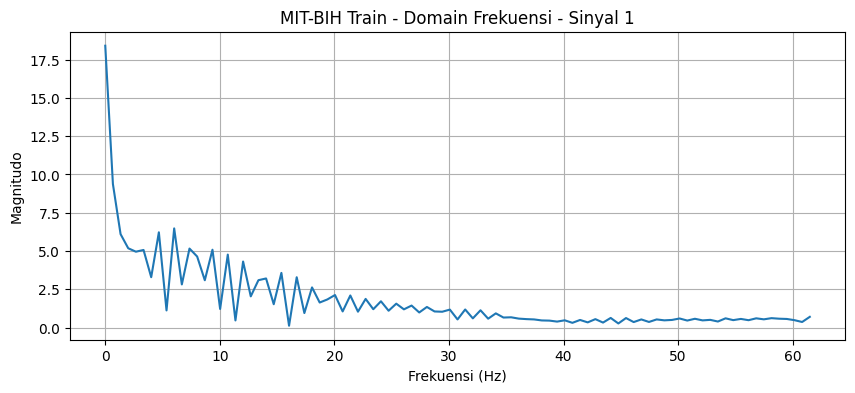

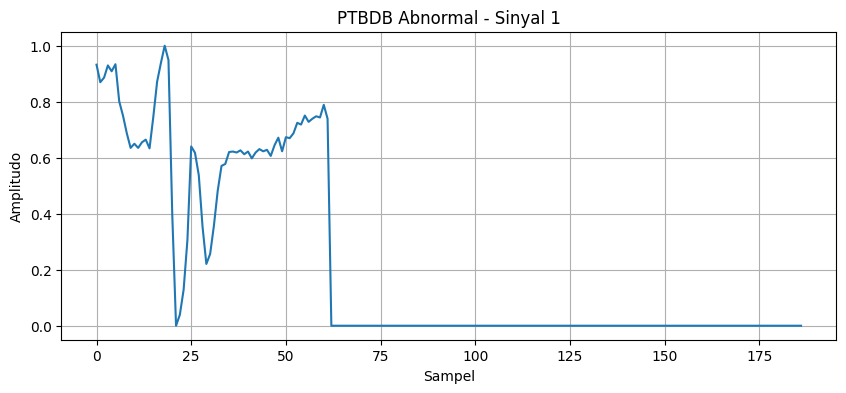

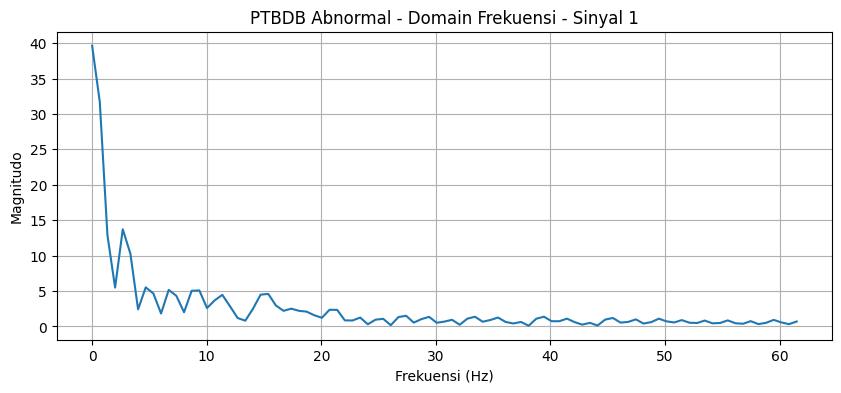

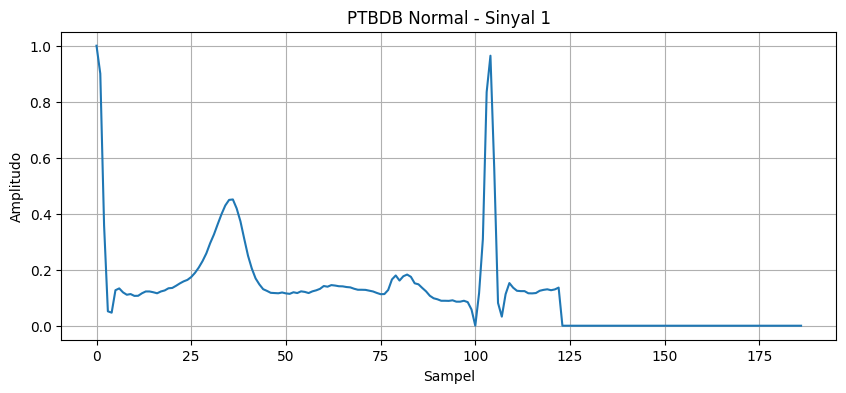

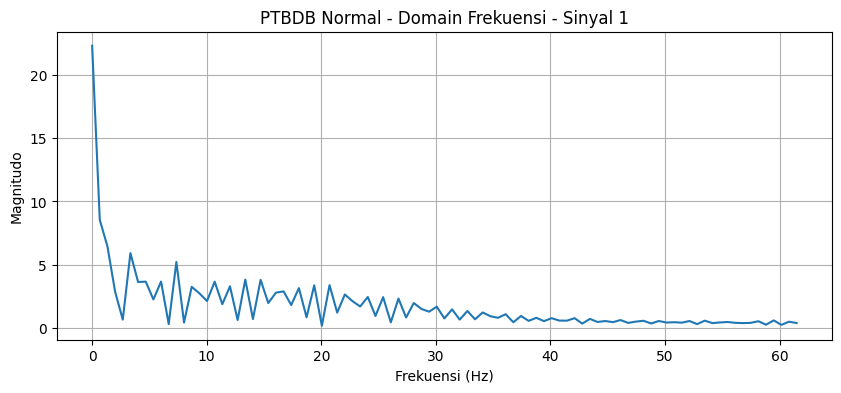

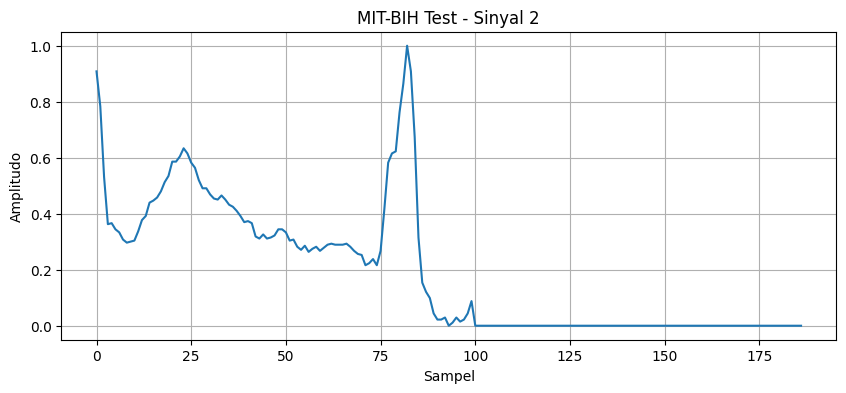

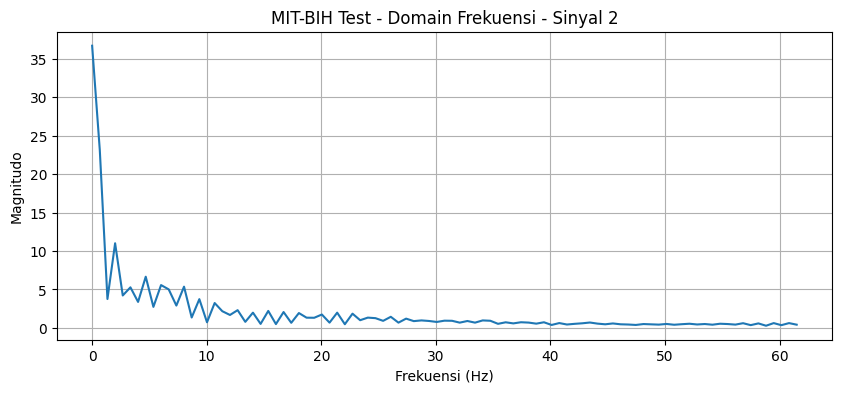

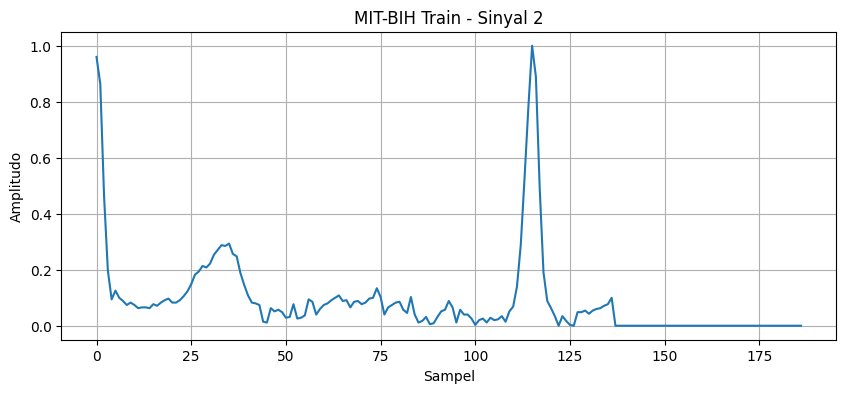

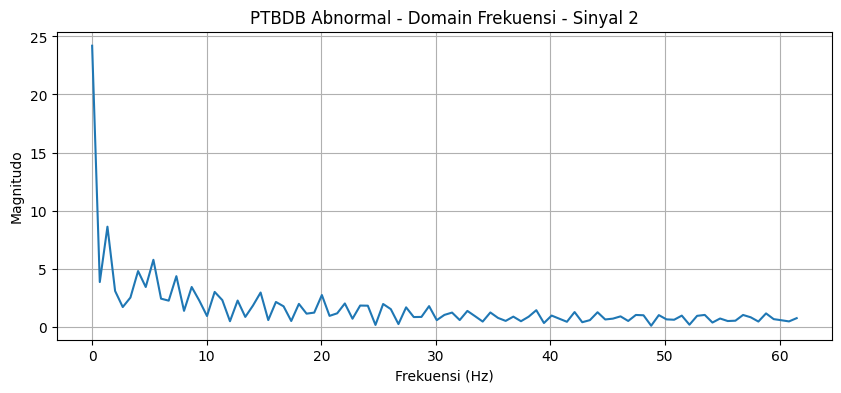

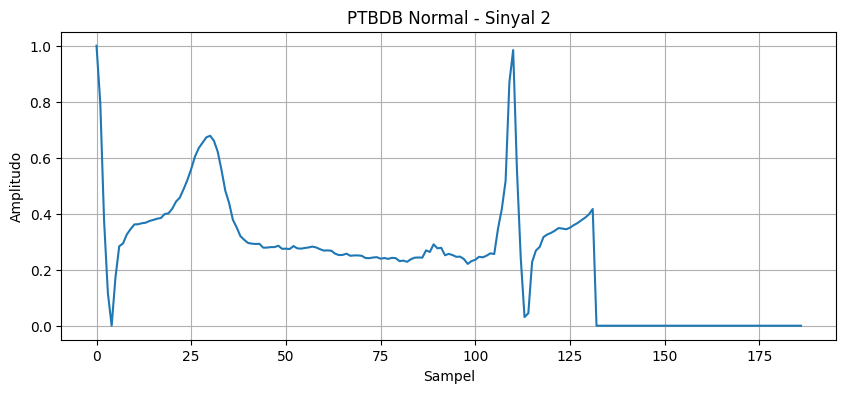

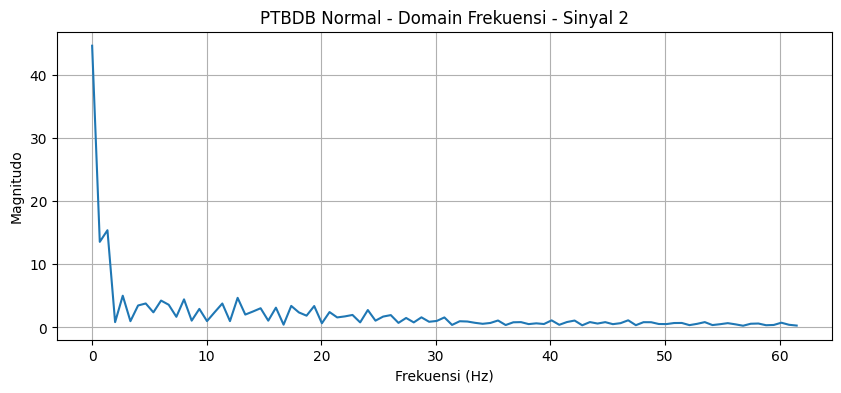

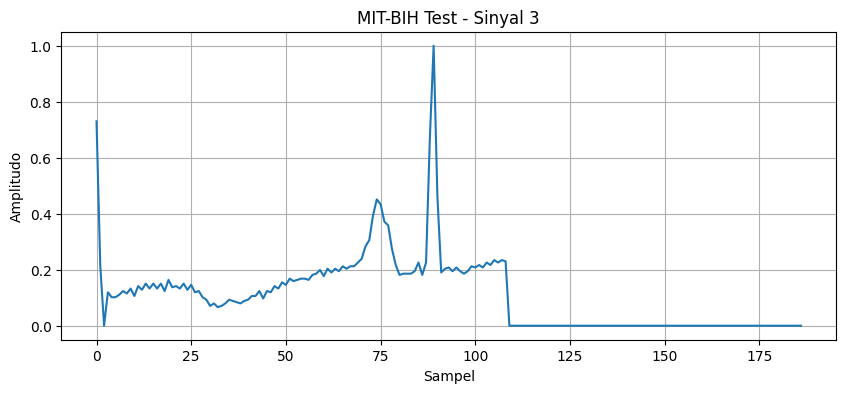

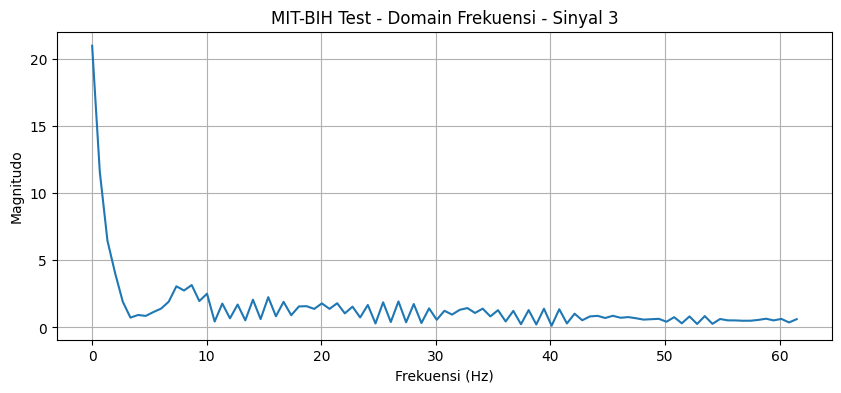

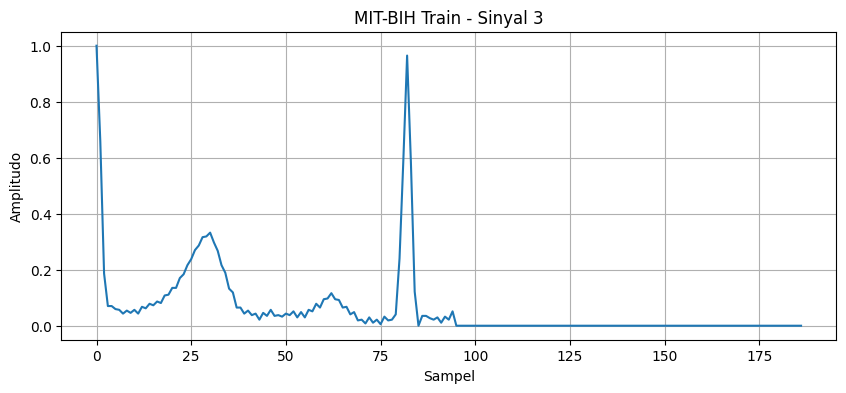

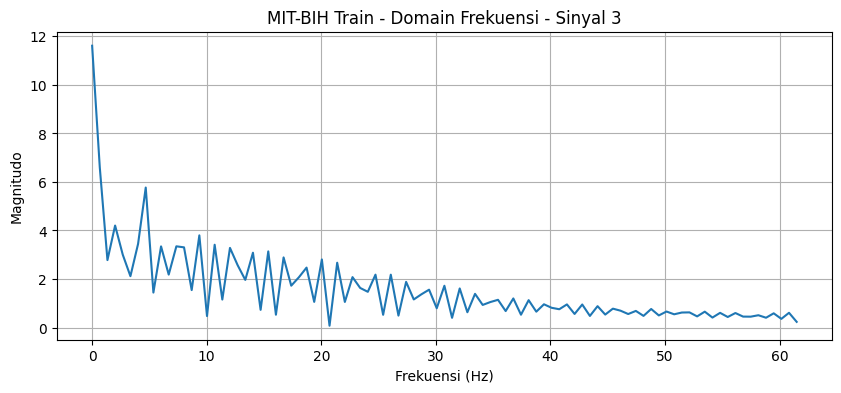

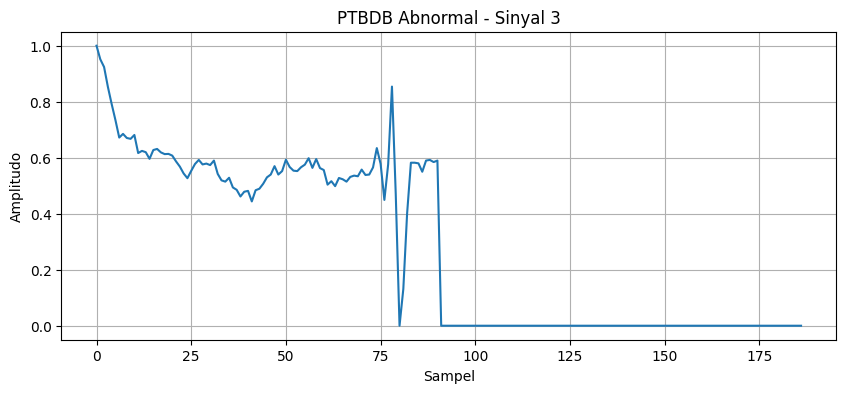

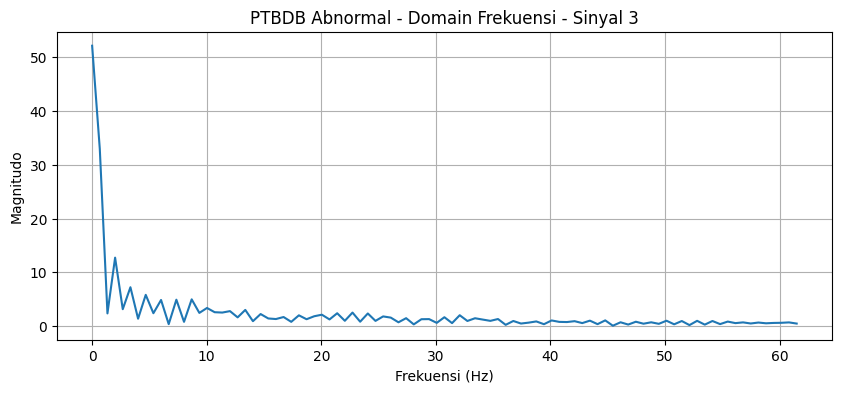

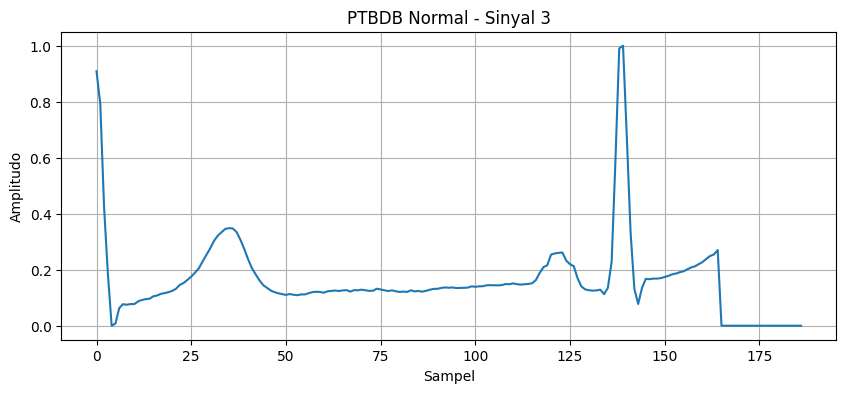

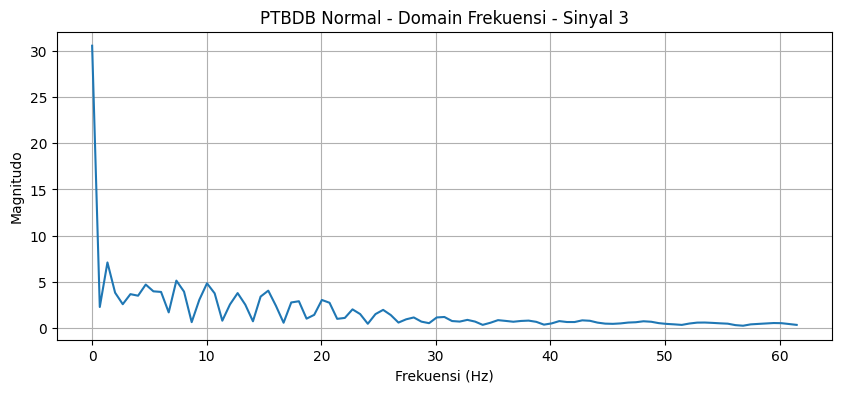

In [87]:
def plot_ecg_signal_frequency(data, title, signal_index):
    if data is not None and not data.empty:
        signal = data.iloc[signal_index, :-1] if data.shape[1] > 1 else data.iloc[signal_index, :]
        fft_result = np.fft.fft(signal)
        freq = np.fft.fftfreq(len(signal), d=1/125)
        plt.figure(figsize=(10, 4))
        plt.plot(freq[:len(freq)//2], np.abs(fft_result[:len(fft_result)//2]))
        plt.title(f'{title} - Domain Frekuensi - Sinyal {signal_index + 1}')
        plt.xlabel('Frekuensi (Hz)')
        plt.ylabel('Magnitudo')
        plt.grid()
        plt.show()


for i in range(3):
    for title, data in datasets.items():
        plot_ecg_signal(data, title, i)
        plot_ecg_signal_frequency(data, title, i)


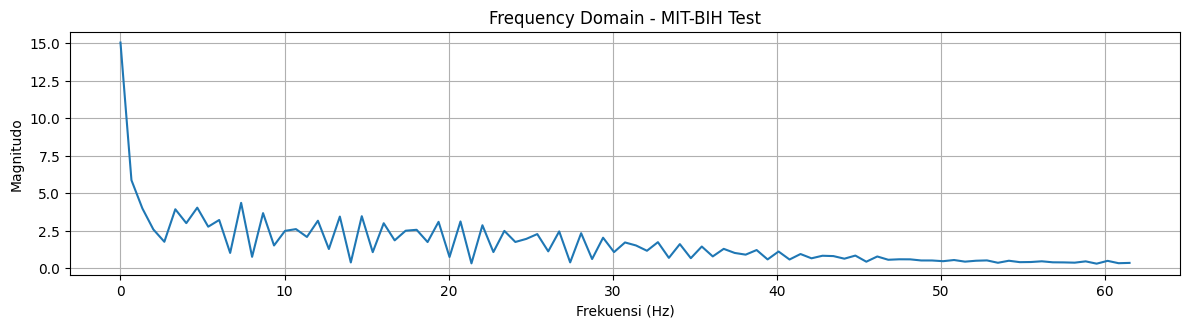

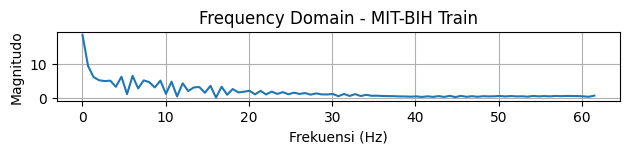

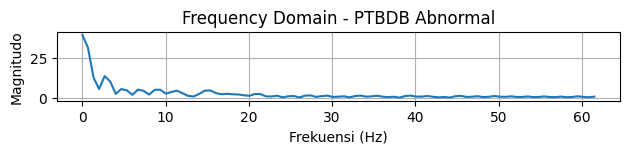

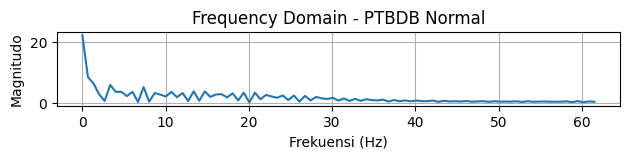

In [88]:
sample_rate = 125
plt.figure(figsize=(12, 12))

for i, (title, file) in enumerate(files.items()):
    ecg_data = pd.read_csv(file, header=None)
    ecg_signal = ecg_data.iloc[0, :-1].values

    N = len(ecg_signal)
    freq = fftfreq(N, d=1/sample_rate)
    fft_values = fft(ecg_signal)
    positive_freq = freq[:N // 2]
    positive_fft_values = abs(fft_values[:N // 2])

    plt.subplot(4, 1, i + 1)
    plt.plot(positive_freq, positive_fft_values)
    plt.title(f"Frequency Domain - {title}")
    plt.xlabel("Frekuensi (Hz)")
    plt.ylabel("Magnitudo")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Normalisasi

In [103]:
mitbih_test_clean = pd.read_csv('/content/mitbih_test.csv')
mitbih_train_clean = pd.read_csv('/content/mitbih_train.csv')
ptbdb_abnormal_clean = pd.read_csv('/content/ptbdb_abnormal.csv')
ptbdb_normal_clean = pd.read_csv('/content/ptbdb_normal.csv')

## Min_max scaler

In [104]:
def min_max_normalization(data):
    min_value = data.min()
    max_value = data.max()

    normalized_data = (data - min_value) / (max_value - min_value)

    return normalized_data


In [105]:
def butterworth_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [106]:
def plot_ecg_signal_time(data, title, signal_index):
    try:
        plt.figure(figsize=(10, 4))
        plt.plot(data.iloc[signal_index, :-1])
        plt.title(f'{title} - Domain Waktu - Sinyal {signal_index + 1}')
        plt.xlabel('Sampel')
        plt.ylabel('Amplitudo')
        plt.grid()
        plt.show()
    except Exception as e:
        print(f"Error plotting time domain for {title} signal {signal_index + 1}: {e}")

In [107]:
def plot_ecg_signal_frequency(data, title, signal_index):
    try:
        sample_rate = 125
        signal = data.iloc[signal_index, :-1]
        signal = pd.to_numeric(signal, errors='coerce')
        signal = signal.dropna()

        if signal.empty:
            return

        fft_result = fft(signal)

        N = len(signal)
        freq = fftfreq(N, d=1/sample_rate)

        plt.figure(figsize=(10, 4))
        plt.plot(freq[:N//2], 2.0/N * np.abs(fft_result[:N//2]))
        plt.title(f'{title} - Domain Frekuensi - Sinyal {signal_index + 1}')
        plt.xlabel('Frekuensi (Hz)')
        plt.ylabel('Magnitudo')
        plt.grid()
        plt.show()
    except Exception as e:
        print(f"Error plotting frequency domain for {title} signal {signal_index + 1}: {e}")


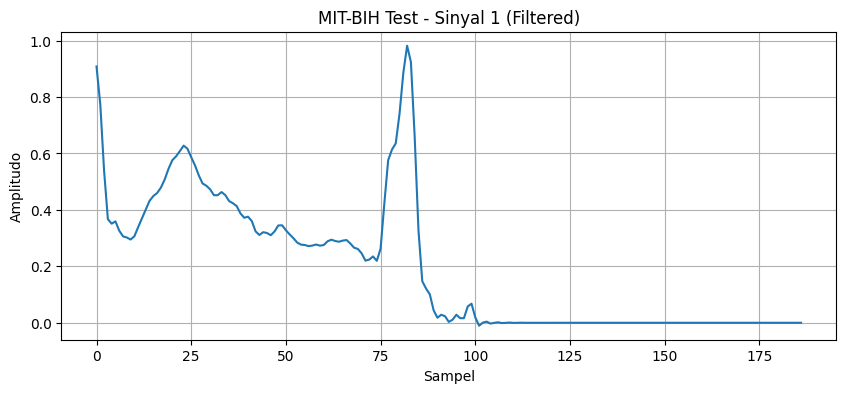

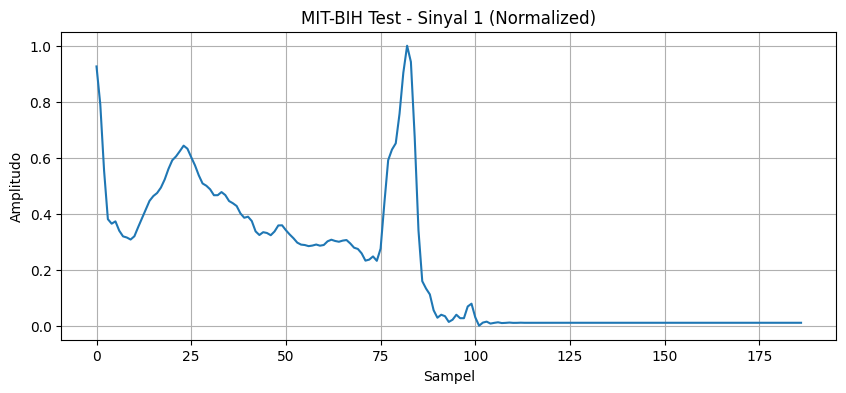

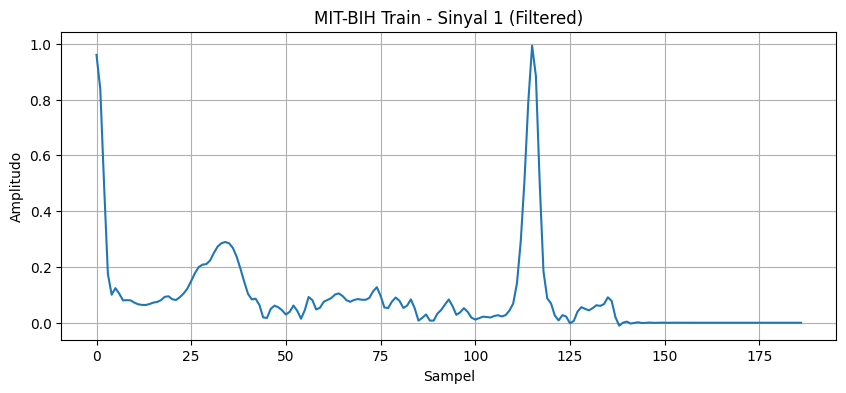

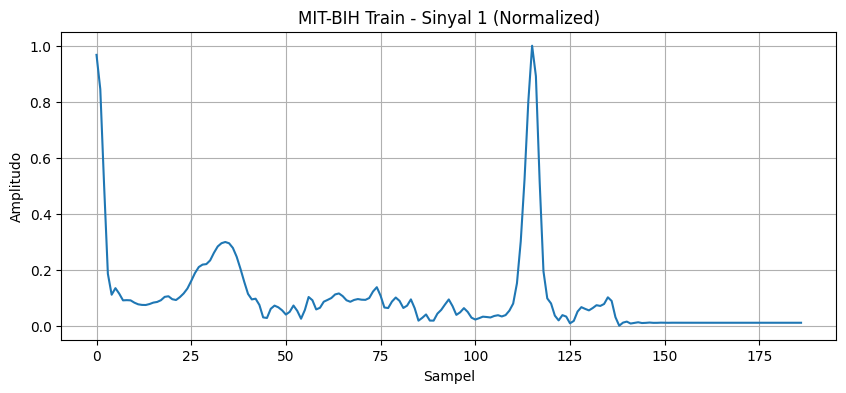

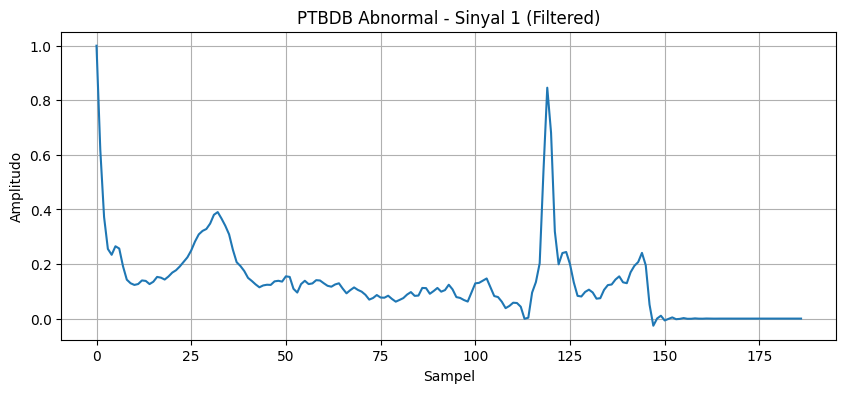

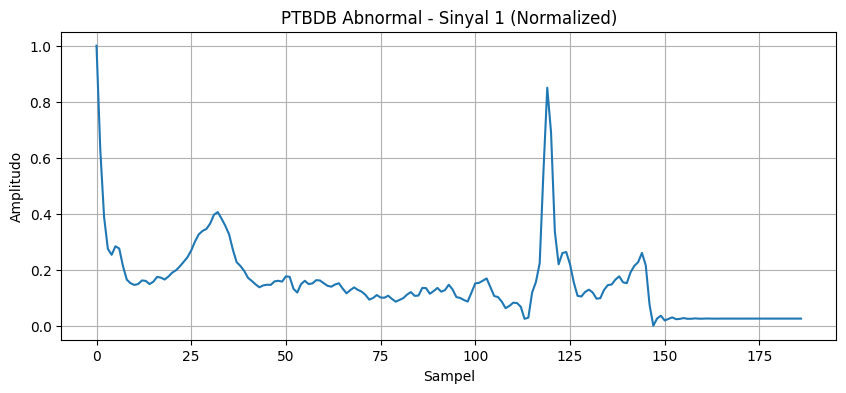

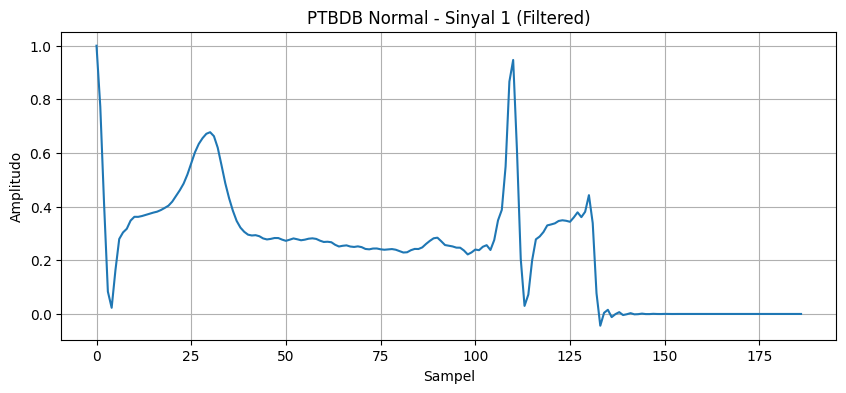

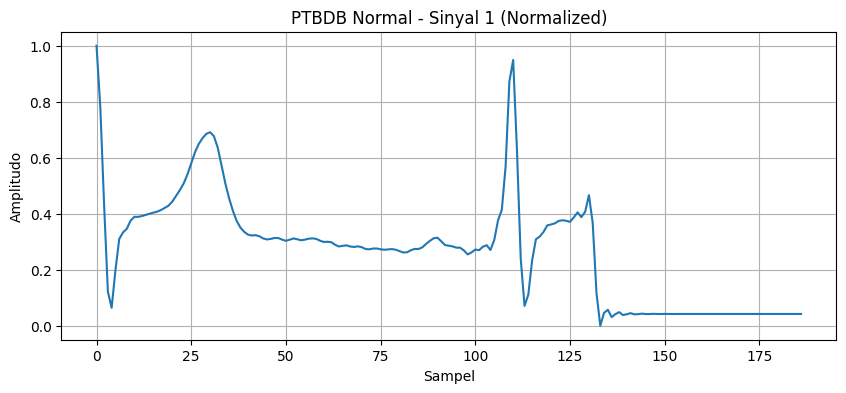

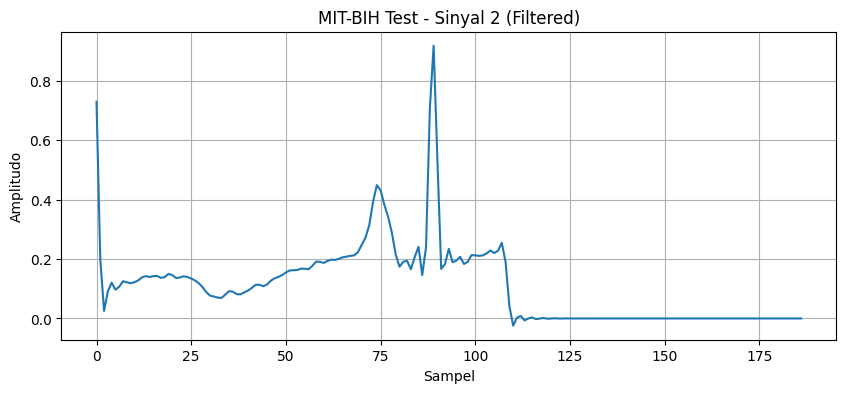

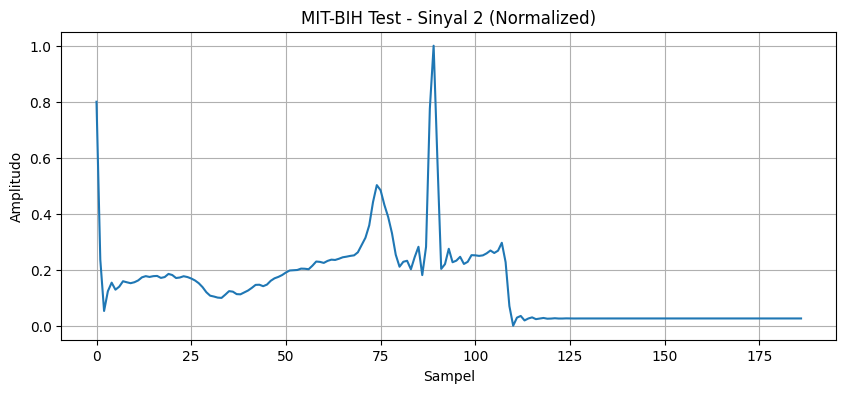

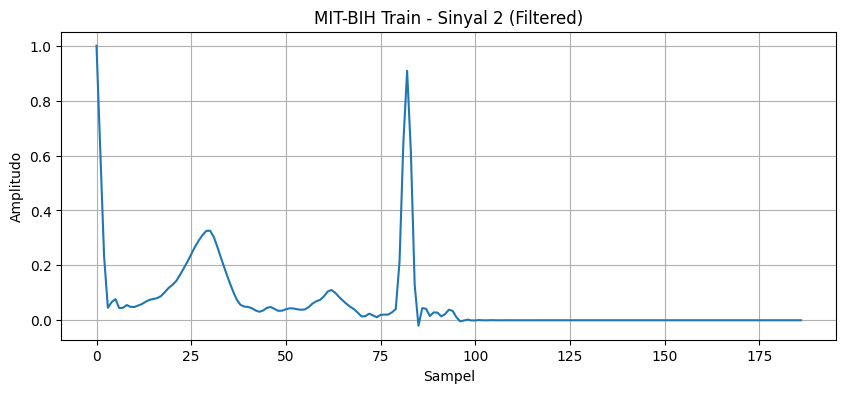

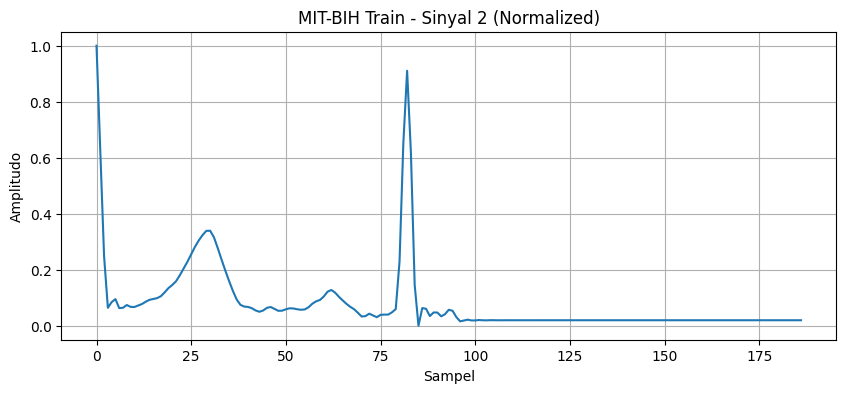

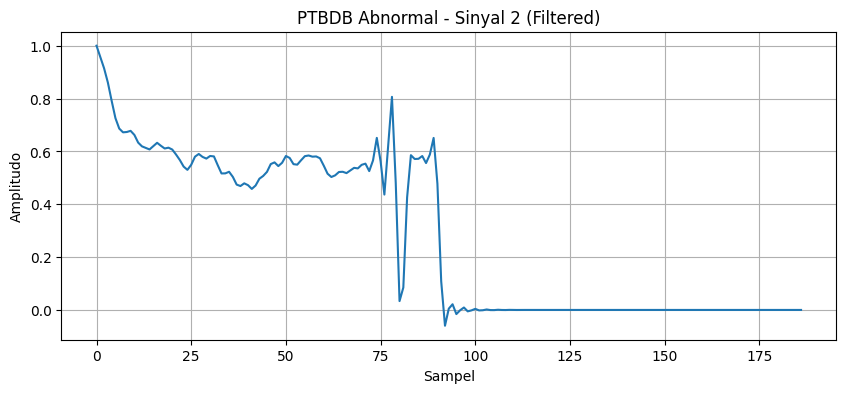

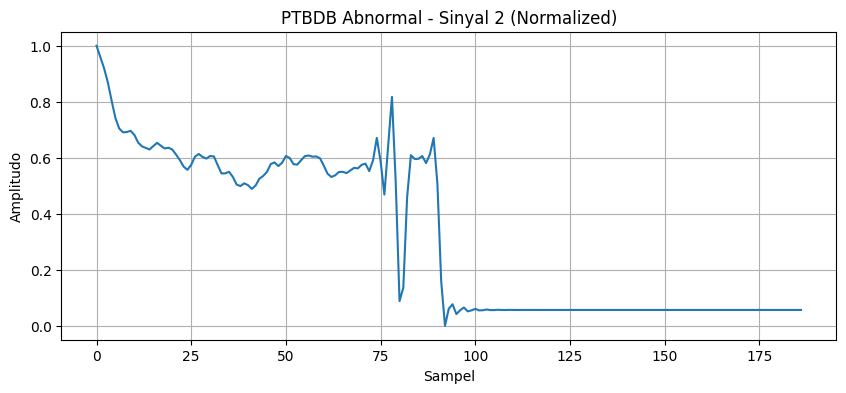

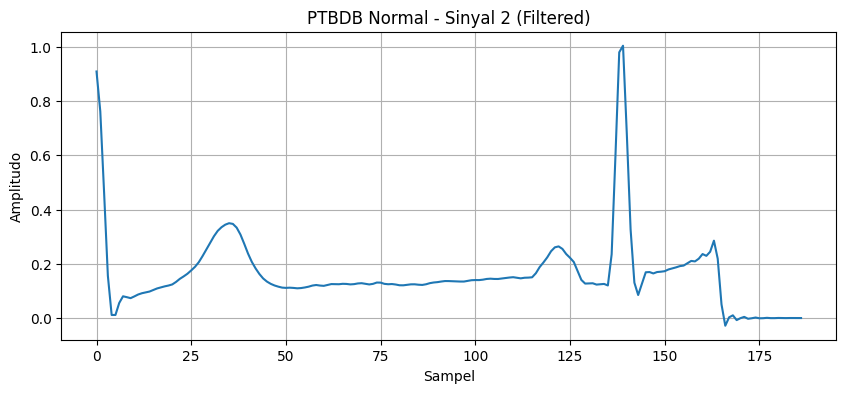

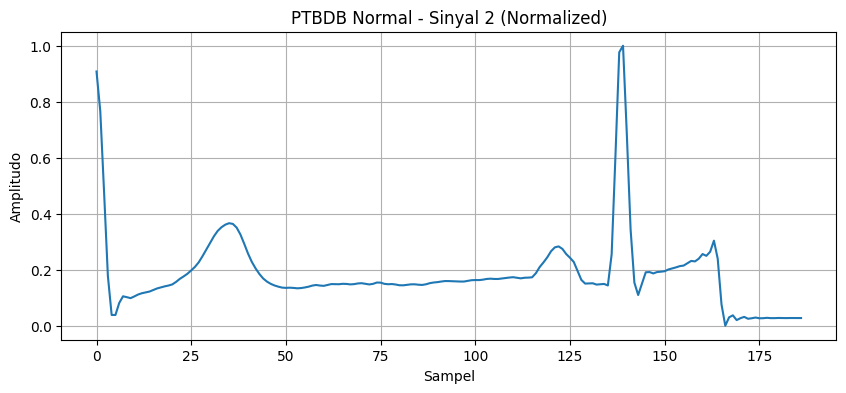

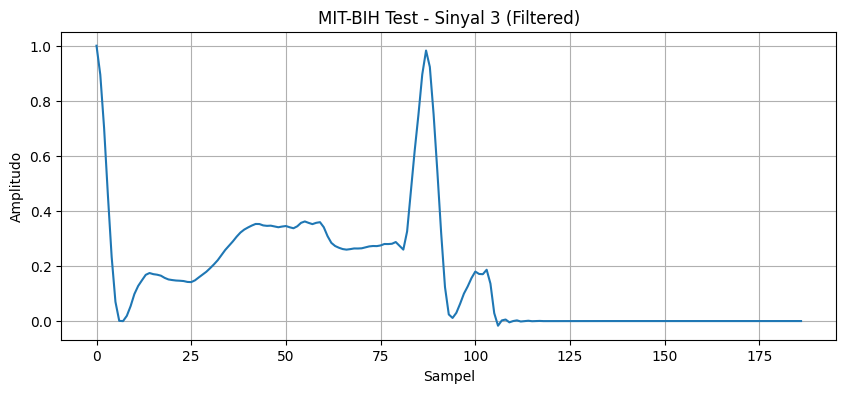

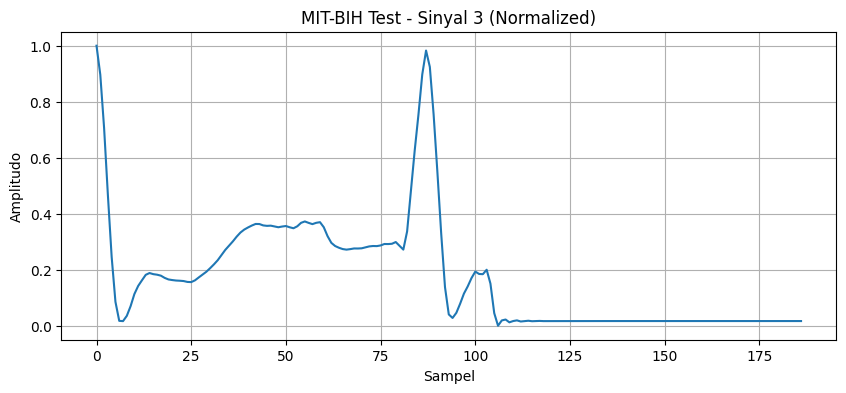

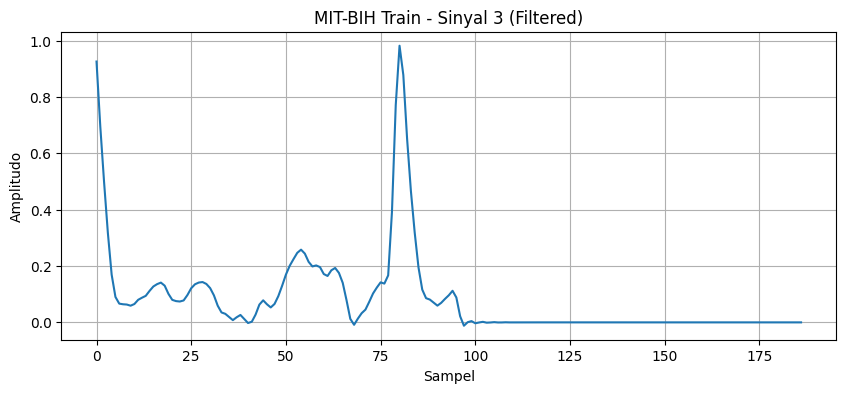

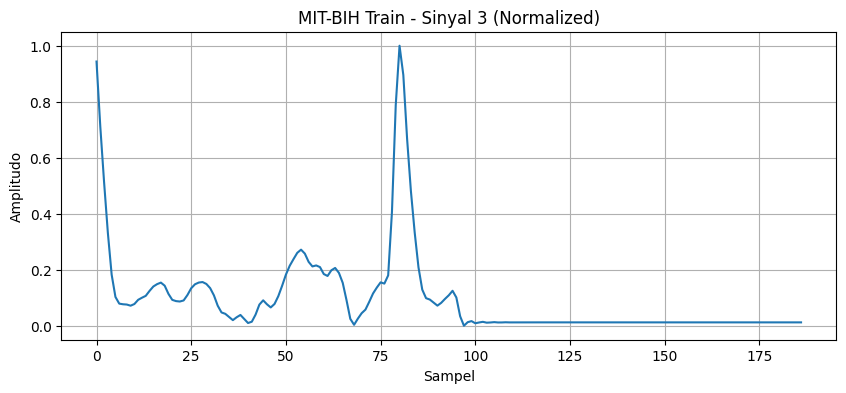

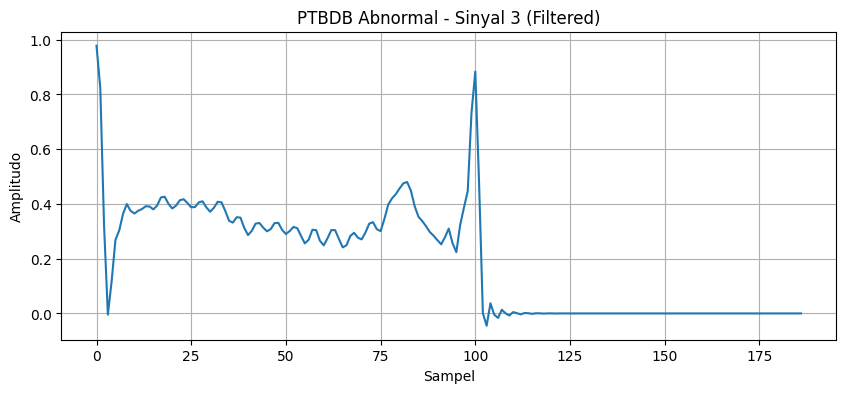

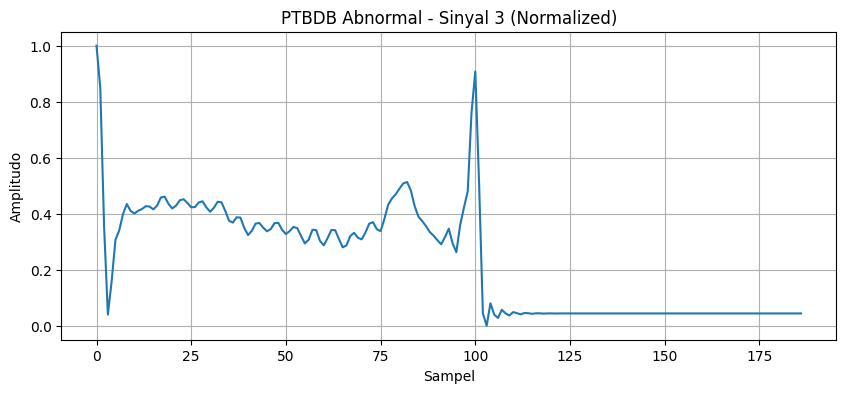

In [143]:
sample_rate = 125
for i in range(3):
    for title, data in datasets.items():
        filtered_signal = butterworth_filter(data.iloc[i, :-1], cutoff=40, fs=sample_rate)

        normalized_signal = min_max_normalization(pd.Series(filtered_signal))

        plt.figure(figsize=(10, 4))
        plt.plot(filtered_signal)
        plt.title(f'{title} - Sinyal {i + 1} (Filtered)')
        plt.xlabel('Sampel')
        plt.ylabel('Amplitudo')
        plt.grid()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(normalized_signal)
        plt.title(f'{title} - Sinyal {i + 1} (Normalized)')
        plt.xlabel('Sampel')
        plt.ylabel('Amplitudo')
        plt.grid()
        plt.show()

        plot_ecg_signal_frequency(pd.DataFrame(normalized_signal), title, i)

In [144]:
datasets = {
    'MIT-BIH Test': mitbih_test_clean,
    'MIT-BIH Train': mitbih_train_clean,
    'PTBDB Abnormal': ptbdb_abnormal_clean,
    'PTBDB Normal': ptbdb_normal_clean
}

mitbih_test_normalized_min_max = min_max_normalization(mitbih_test_clean.iloc[:, :-1])
mitbih_train_normalized_min_max = min_max_normalization(mitbih_train_clean.iloc[:, :-1])
ptbdb_abnormal_normalized_min_max = min_max_normalization(ptbdb_abnormal_clean.iloc[:, :-1])
ptbdb_normal_normalized_min_max = min_max_normalization(ptbdb_normal_clean.iloc[:, :-1])


print("MIT-BIH Test Normalized (Min-Max):")
print(mitbih_test_normalized_min_max.head())

print("\nMIT-BIH Train Normalized (Min-Max):")
print(mitbih_train_normalized_min_max.head())

print("\nPTBDB Abnormal Normalized (Min-Max):")
print(ptbdb_abnormal_normalized_min_max.head())

print("\nPTBDB Normal Normalized (Min-Max):")
print(ptbdb_normal_normalized_min_max.head())

MIT-BIH Test Normalized (Min-Max):
   1.000000000000000000e+00  7.582644820213317871e-01  \
0                  0.908425                  0.783883   
1                  0.730088                  0.212389   
2                  1.000000                  0.910417   
3                  0.570470                  0.399329   
4                  1.000000                  0.923664   

   1.115702465176582336e-01  0.000000000000000000e+00  \
0                  0.531136                  0.362637   
1                  0.000000                  0.119469   
2                  0.681250                  0.472917   
3                  0.238255                  0.147651   
4                  0.656489                  0.195929   

   8.057851344347000122e-02  7.851240038871765137e-02  \
0                  0.366300                  0.344322   
1                  0.101770                  0.101770   
2                  0.229167                  0.068750   
3                  0.000000                  0.0033

## Z_score scaler

In [145]:
def z_score_normalization(data):
    mean_value = data.mean()
    std_dev = data.std()
    normalized_data = (data - mean_value) / std_dev
    return normalized_data

In [146]:
mitbih_test_normalized_z_score = z_score_normalization(mitbih_test_clean.iloc[:, :-1])
mitbih_train_normalized_z_score = z_score_normalization(mitbih_train_clean.iloc[:, :-1])
ptbdb_abnormal_normalized_z_score = z_score_normalization(ptbdb_abnormal_clean.iloc[:, :-1])
ptbdb_normal_normalized_z_score = z_score_normalization(ptbdb_normal_clean.iloc[:, :-1])

In [147]:
print("\nMIT-BIH Test Normalized (Z-Score):")
print(mitbih_test_normalized_z_score.head())

print("\nMIT-BIH Train Normalized (Z-Score):")
print(mitbih_train_normalized_z_score.head())

print("\nPTBDB Abnormal Normalized (Z-Score):")
print(ptbdb_abnormal_normalized_z_score.head())

print("\nPTBDB Normal Normalized (Z-Score):")
print(ptbdb_normal_normalized_z_score.head())


MIT-BIH Test Normalized (Z-Score):
   1.000000000000000000e+00  7.582644820213317871e-01  \
0                  0.059770                  0.100521   
1                 -0.700518                 -2.513044   
2                  0.450174                  0.679189   
3                 -1.381008                 -1.658129   
4                  0.450174                  0.739772   

   1.115702465176582336e-01  0.000000000000000000e+00  \
0                  0.457171                  0.675727   
1                 -1.866585                 -0.489373   
2                  1.113932                  1.204112   
3                 -0.824202                 -0.354344   
4                  1.005599                 -0.123029   

   8.057851344347000122e-02  7.851240038871765137e-02  \
0                  0.926231                  0.780658   
1                 -0.562156                 -0.627930   
2                  0.154645                 -0.819688   
3                 -1.134766                 -1.199

## Segmentation

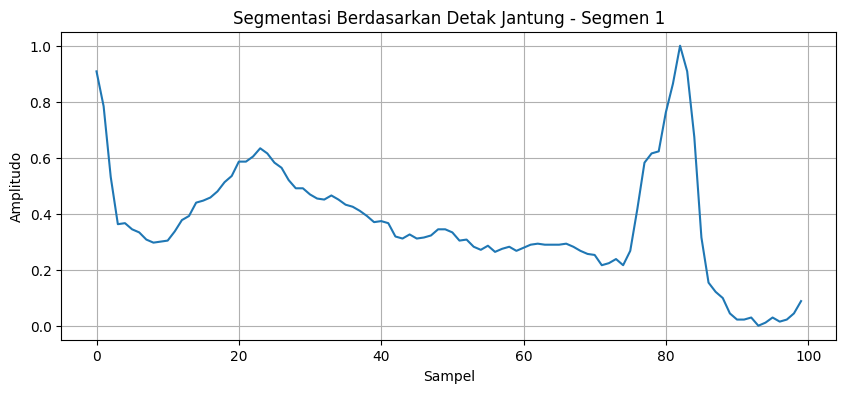

Jumlah segmen berdasarkan waktu: 0
Jumlah segmen berdasarkan detak jantung: 1


In [148]:
def segment_by_time(signal, window_size, sample_rate):
    window_samples = int(window_size * sample_rate)
    segments = [signal[i:i + window_samples] for i in range(0, len(signal), window_samples) if i + window_samples <= len(signal)]
    return segments


def segment_by_heart_rate(signal, heart_rate, sample_rate):
    interval_samples = int((60 / heart_rate) * sample_rate)
    segments = [signal[i:i + interval_samples] for i in range(0, len(signal), interval_samples) if i + interval_samples <= len(signal)]
    return segments

sample_rate = 125
window_size = 2.0

signal_test = mitbih_test_clean.iloc[0, :-1].values
segments_time = segment_by_time(signal_test, window_size, sample_rate)

for i, segment in enumerate(segments_time):
    plt.figure(figsize=(10, 4))
    plt.plot(segment)
    plt.title(f'Segmentasi Berdasarkan Waktu - Segmen {i + 1}')
    plt.xlabel('Sampel')
    plt.ylabel('Amplitudo')
    plt.grid()
    plt.show()


heart_rate = 75
segments_heart_rate = segment_by_heart_rate(signal_test, heart_rate, sample_rate)

for i, segment in enumerate(segments_heart_rate):
    plt.figure(figsize=(10, 4))
    plt.plot(segment)
    plt.title(f'Segmentasi Berdasarkan Detak Jantung - Segmen {i + 1}')
    plt.xlabel('Sampel')
    plt.ylabel('Amplitudo')
    plt.grid()
    plt.show()

print(f"Jumlah segmen berdasarkan waktu: {len(segments_time)}")
print(f"Jumlah segmen berdasarkan detak jantung: {len(segments_heart_rate)}")



## Deteksi Puncak

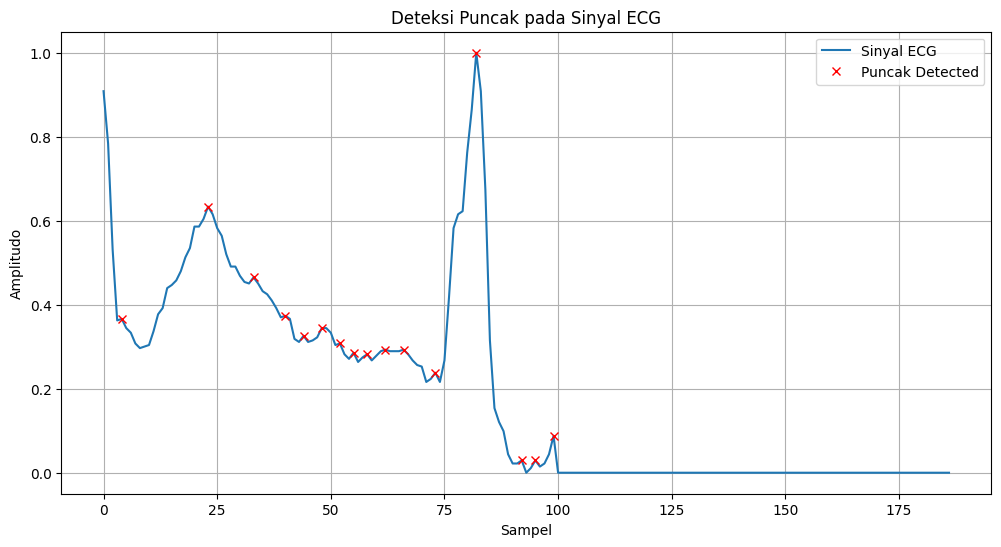

Jumlah puncak yang terdeteksi: 16
Indeks puncak: [ 4 23 33 40 44 48 52 55 58 62 66 73 82 92 95 99]


In [149]:
peaks, _ = find_peaks(signal_test, height=0)
plt.figure(figsize=(12, 6))
plt.plot(signal_test, label='Sinyal ECG')
plt.plot(peaks, signal_test[peaks], "x", label='Puncak Detected', color='red')
plt.title('Deteksi Puncak pada Sinyal ECG')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.grid()
plt.show()

print(f"Jumlah puncak yang terdeteksi: {len(peaks)}")
print(f"Indeks puncak: {peaks}")

## Deteksi Anomali

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.fftpack import fft


def detect_anomalies_threshold(signal, threshold):
    anomalies = np.where(np.abs(signal) > threshold)[0]
    return anomalies

def detect_anomalies_ml(signal):
    scaler = StandardScaler()
    signal_scaled = scaler.fit_transform(signal.reshape(-1, 1))
    model = IsolationForest(contamination=0.05, random_state=42)
    anomalies = model.fit_predict(signal_scaled)
    return np.where(anomalies == -1)[0]

def transform_frequency(signal, sample_rate):
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1/sample_rate)
    spectrum = np.abs(fft(signal))[:n//2]
    return freq[:n//2], spectrum

def augment_signal(signal, noise_factor=0.01, time_stretch=1.2):
    noise = noise_factor * np.random.normal(size=len(signal))
    noisy_signal = signal + noise
    stretched_signal = np.interp(
        np.arange(0, len(signal), time_stretch),
        np.arange(0, len(signal)),
        signal
    )
    return noisy_signal, stretched_signal


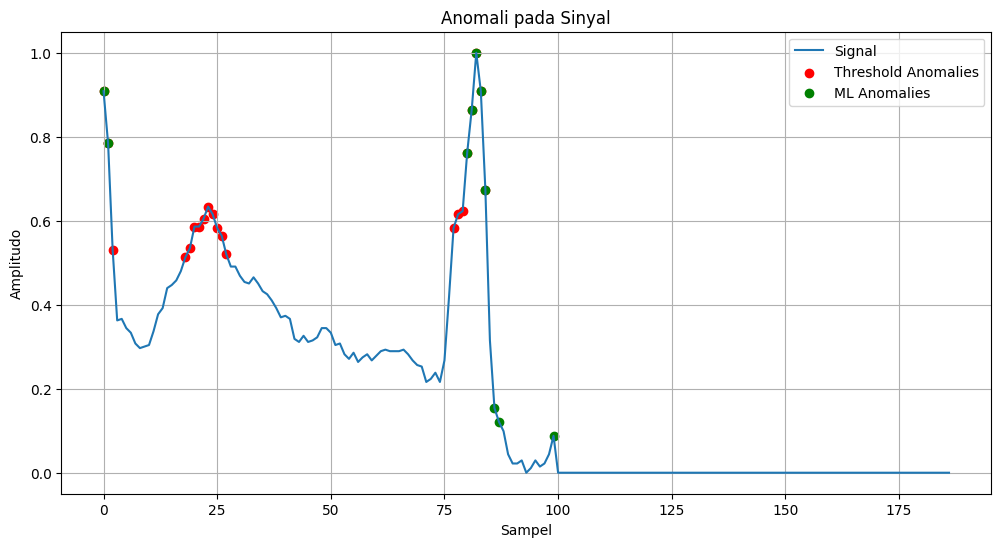

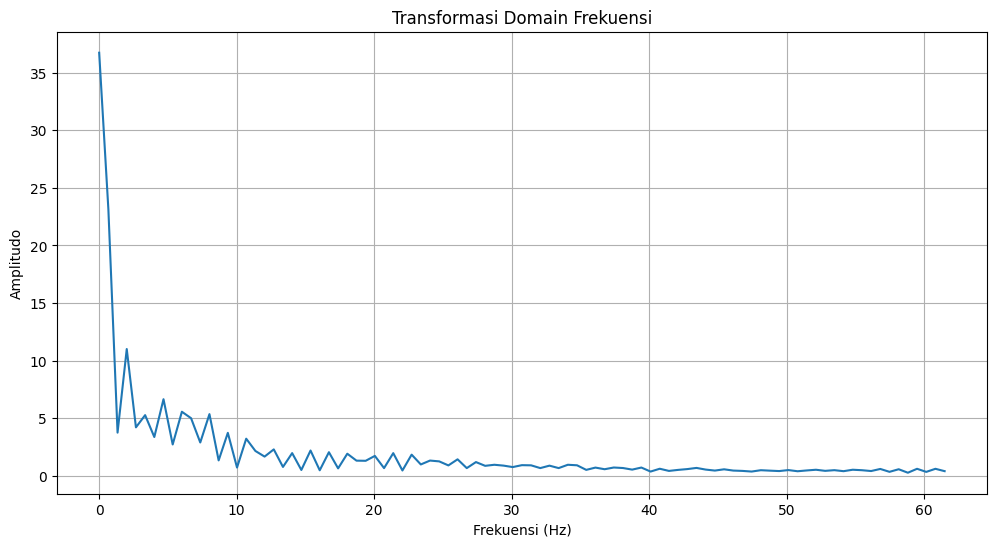

In [151]:
sample_signal = mitbih_test_clean.iloc[0, :-1].values
threshold = 0.5
anomalies_threshold = detect_anomalies_threshold(sample_signal, threshold)
anomalies_ml = detect_anomalies_ml(sample_signal)

plt.figure(figsize=(12, 6))
plt.plot(sample_signal, label='Signal')
plt.scatter(anomalies_threshold, sample_signal[anomalies_threshold], color='red', label='Threshold Anomalies')
plt.scatter(anomalies_ml, sample_signal[anomalies_ml], color='green', label='ML Anomalies')
plt.title('Anomali pada Sinyal')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.grid()
plt.show()

sample_rate = 125
freq, spectrum = transform_frequency(sample_signal, sample_rate)

plt.figure(figsize=(12, 6))
plt.plot(freq, spectrum)
plt.title('Transformasi Domain Frekuensi')
plt.xlabel('Frekuensi (Hz)')
plt.ylabel('Amplitudo')
plt.grid()
plt.show()


## Augmentasi Data

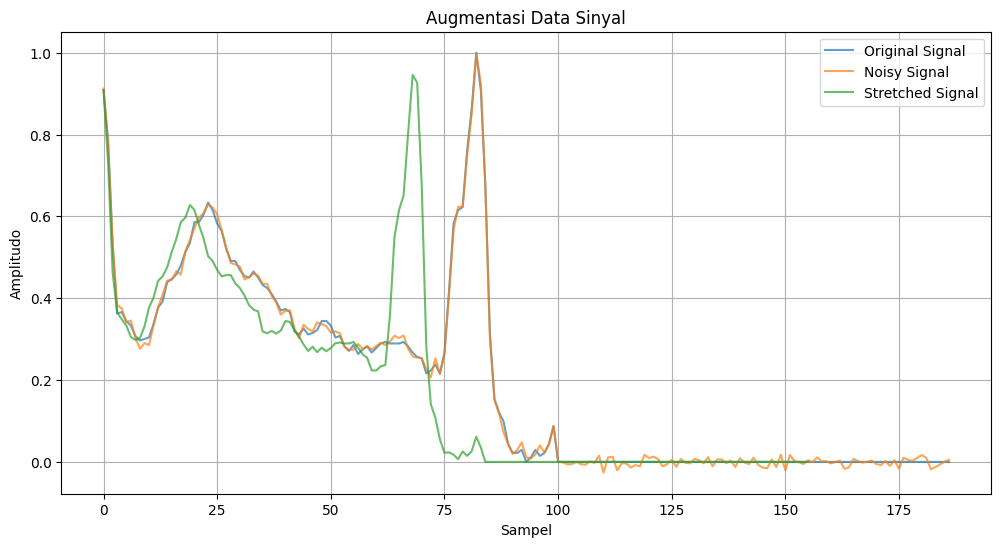

In [152]:
noisy_signal, stretched_signal = augment_signal(sample_signal)

plt.figure(figsize=(12, 6))
plt.plot(sample_signal, label='Original Signal', alpha=0.7)
plt.plot(noisy_signal, label='Noisy Signal', alpha=0.7)
plt.plot(stretched_signal, label='Stretched Signal', alpha=0.7)
plt.title('Augmentasi Data Sinyal')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.grid()
plt.show()

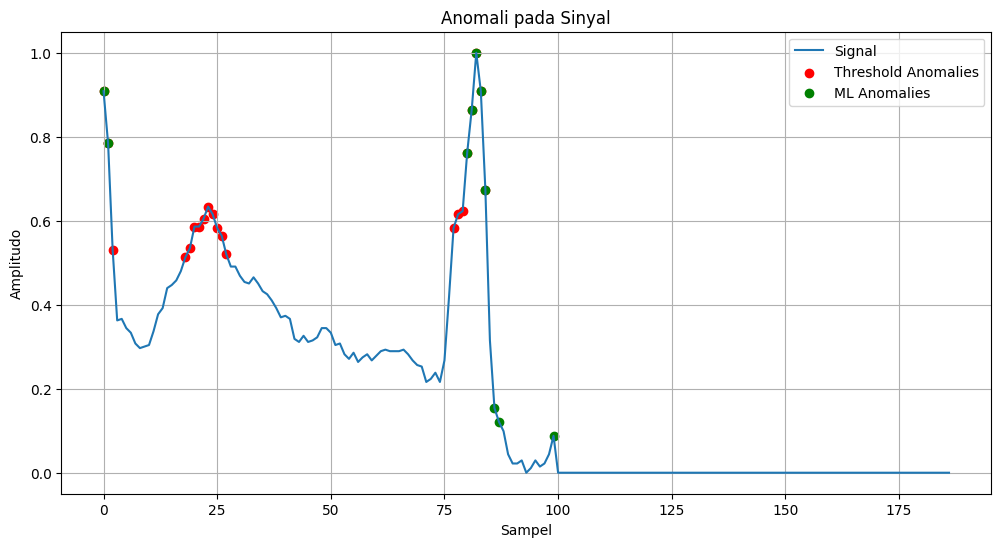

In [153]:
def detect_anomalies_threshold(signal, threshold):
    anomalies = np.where(np.abs(signal) > threshold)[0]
    return anomalies

def detect_anomalies_ml(signal):
    scaler = StandardScaler()
    signal_scaled = scaler.fit_transform(signal.reshape(-1, 1))
    model = IsolationForest(contamination=0.05, random_state=42)
    anomalies = model.fit_predict(signal_scaled)
    return np.where(anomalies == -1)[0]

def transform_frequency(signal, sample_rate):
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1/sample_rate)
    spectrum = np.abs(fft(signal))[:n//2]
    return freq[:n//2], spectrum

def augment_signal(signal, noise_factor=0.01, time_stretch=1.2):
    noise = noise_factor * np.random.normal(size=len(signal))
    noisy_signal = signal + noise
    stretched_signal = np.interp(
        np.arange(0, len(signal), time_stretch),
        np.arange(0, len(signal)),
        signal
    )
    return noisy_signal, stretched_signal

def remove_noise(signal, lowcut, highcut, sample_rate, order=5):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

plt.figure(figsize=(12, 6))
plt.plot(sample_signal, label='Signal')
plt.scatter(anomalies_threshold, sample_signal[anomalies_threshold], color='red', label='Threshold Anomalies')
plt.scatter(anomalies_ml, sample_signal[anomalies_ml], color='green', label='ML Anomalies')
plt.title('Anomali pada Sinyal')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.grid()
plt.show()

## RR Intevals

- Memberikan informasi tentang irama jantung (reguler atau tidak).

- Variabilitas interval RR membantu mendeteksi aritmia seperti Fibrilasi Atrium.

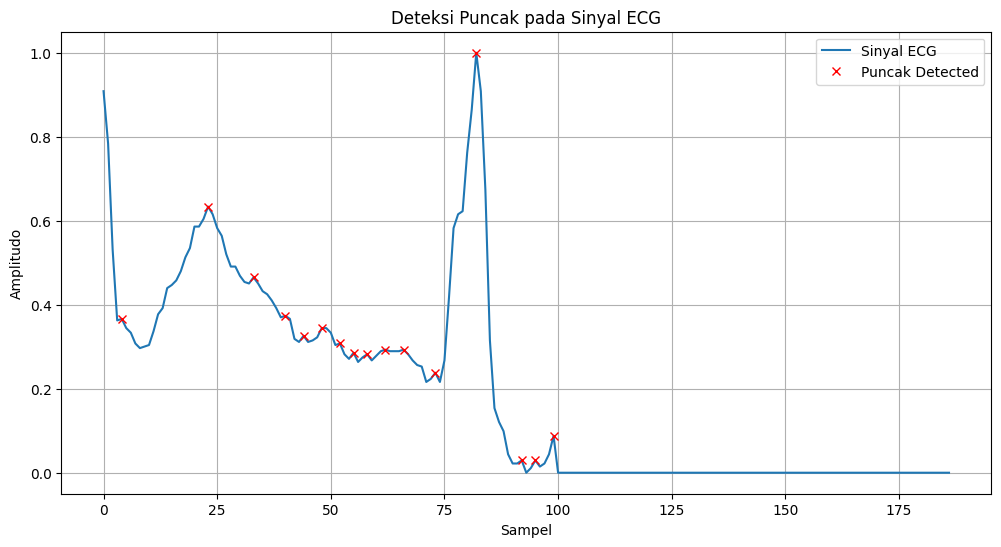

Jumlah puncak yang terdeteksi: 16
Indeks puncak: [ 4 23 33 40 44 48 52 55 58 62 66 73 82 92 95 99]
Interval RR (dalam detik): [0.152 0.08  0.056 0.032 0.032 0.032 0.024 0.024 0.032 0.032 0.056 0.072
 0.08  0.024 0.032]


In [154]:
rr_intervals = np.diff(peaks)
rr_intervals_seconds = rr_intervals / 125

plt.figure(figsize=(12, 6))
plt.plot(signal_test, label='Sinyal ECG')
plt.plot(peaks, signal_test[peaks], "x", label='Puncak Detected', color='red')
plt.title('Deteksi Puncak pada Sinyal ECG')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.grid()
plt.show()

print(f"Jumlah puncak yang terdeteksi: {len(peaks)}")
print(f"Indeks puncak: {peaks}")
print(f"Interval RR (dalam detik): {rr_intervals_seconds}")

<ipython-input-155-682ab77cf40f>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(peaks_r, signal[peaks_r], "x", label='Puncak R Detected', color='red')
<ipython-input-155-682ab77cf40f>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(q_peaks, signal[q_peaks], "o", label='Puncak Q Detected', color='blue')
<ipython-input-155-682ab77cf40f>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(s_peaks, signal[s

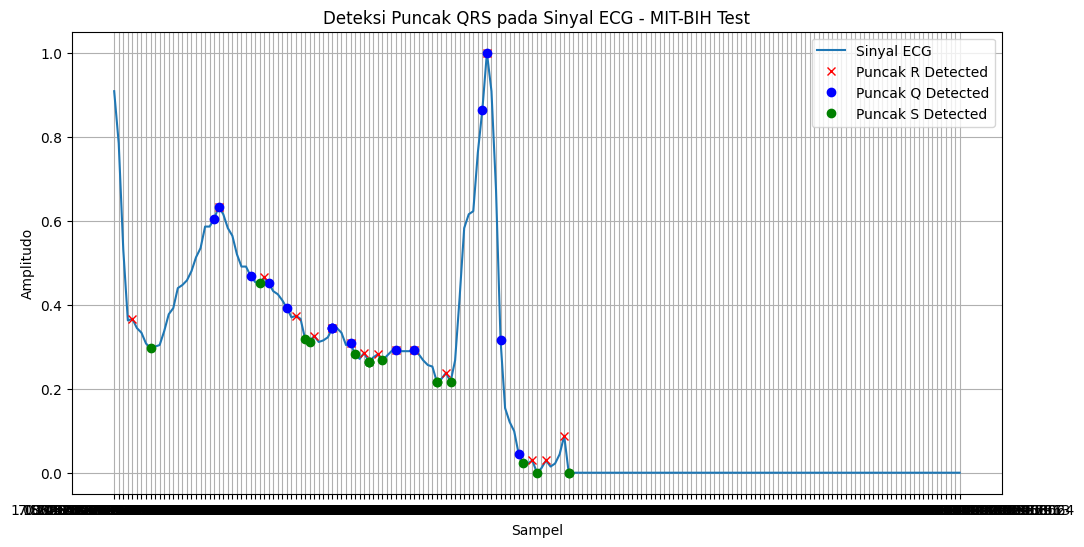

Dataset: MIT-BIH Test
Jumlah interval QRS yang terdeteksi: 15
Durasi Interval QRS (dalam detik): [np.float64(-0.112), np.float64(0.072), np.float64(0.096), np.float64(0.072), np.float64(0.12), np.float64(0.064), np.float64(0.064), np.float64(0.064), np.float64(0.056), np.float64(0.072), np.float64(0.04), np.float64(-0.056), np.float64(0.064), np.float64(0.064), np.float64(0.088)]



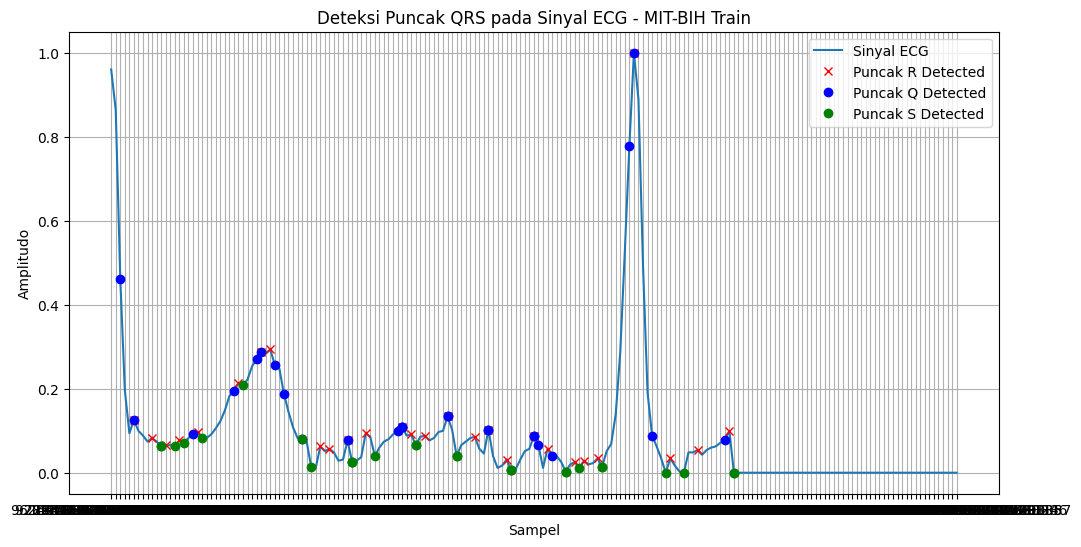

Dataset: MIT-BIH Train
Jumlah interval QRS yang terdeteksi: 26
Durasi Interval QRS (dalam detik): [np.float64(0.072), np.float64(0.048), np.float64(-0.032), np.float64(-0.088), np.float64(-0.096), np.float64(-0.032), np.float64(0.048), np.float64(0.048), np.float64(0.088), np.float64(0.008), np.float64(-0.08), np.float64(-0.048), np.float64(0.024), np.float64(0.024), np.float64(0.016), np.float64(0.016), np.float64(0.04), np.float64(0.04), np.float64(-0.04), np.float64(0.056), np.float64(0.048), np.float64(0.048), np.float64(-0.048), np.float64(-0.056), np.float64(0.024), np.float64(-0.072)]



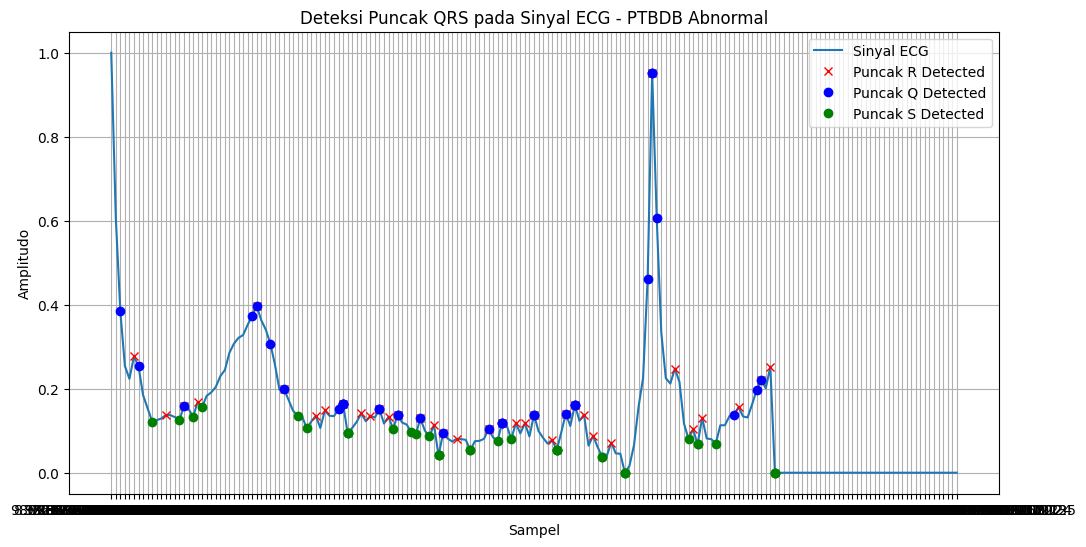

Dataset: PTBDB Abnormal
Jumlah interval QRS yang terdeteksi: 35
Durasi Interval QRS (dalam detik): [np.float64(0.056), np.float64(0.072), np.float64(0.016), np.float64(-0.088), np.float64(0.072), np.float64(0.064), np.float64(0.112), np.float64(0.016), np.float64(0.008), np.float64(0.088), np.float64(0.12), np.float64(0.128), np.float64(0.088), np.float64(0.104), np.float64(0.072), np.float64(0.072), np.float64(0.088), np.float64(0.048), np.float64(0.016), np.float64(0.016), np.float64(0.096), np.float64(0.096), np.float64(0.04), np.float64(0.04), np.float64(0.064), np.float64(0.048), np.float64(0.088), np.float64(0.088), np.float64(-0.04), np.float64(0.064), np.float64(0.08), np.float64(0.072), np.float64(-0.032), np.float64(0.032), np.float64(0.024)]



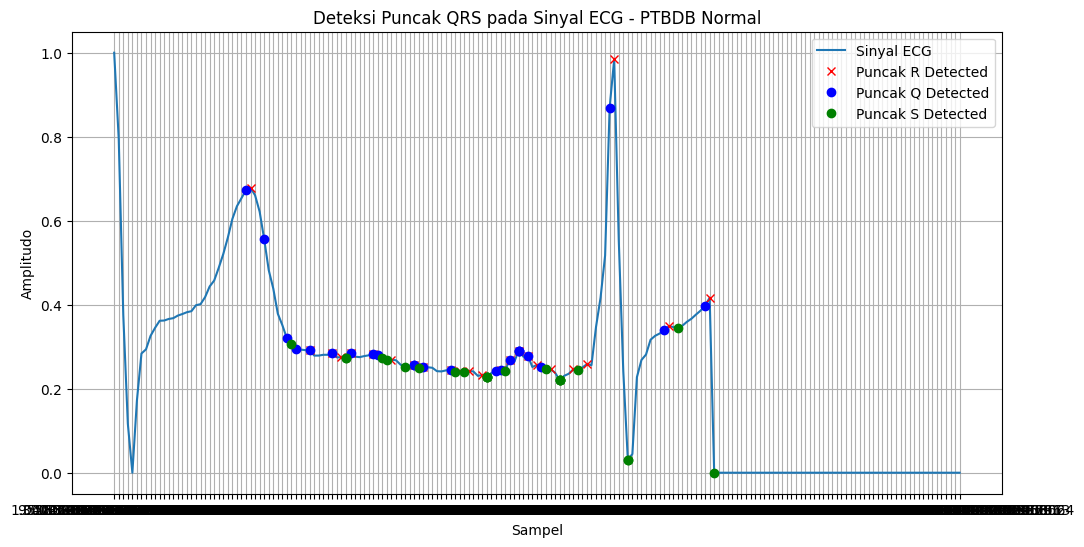

Dataset: PTBDB Normal
Jumlah interval QRS yang terdeteksi: 24
Durasi Interval QRS (dalam detik): [np.float64(0.08), np.float64(0.144), np.float64(0.104), np.float64(0.152), np.float64(0.136), np.float64(0.128), np.float64(0.12), np.float64(0.144), np.float64(0.152), np.float64(0.128), np.float64(0.128), np.float64(0.112), np.float64(0.064), np.float64(0.016), np.float64(0.08), np.float64(0.088), np.float64(0.072), np.float64(0.072), np.float64(0.072), np.float64(0.088), np.float64(0.152), np.float64(0.032), np.float64(0.024), np.float64(0.016)]



In [155]:
def extract_qrs_duration(signal):
    peaks_r, _ = find_peaks(signal, height=0)

    q_peaks = []
    s_peaks = []

    for r_peak in peaks_r:
        if r_peak > 10:
            q_peak = np.argmax(signal[r_peak-10:r_peak]) + (r_peak - 10)
            q_peaks.append(q_peak)

        if r_peak < len(signal) - 10:
            s_peak = np.argmin(signal[r_peak:r_peak+10]) + r_peak
            s_peaks.append(s_peak)

    qrs_durations = []
    for q_peak, s_peak in zip(q_peaks, s_peaks):
        qrs_duration = (s_peak - q_peak) / 125
        qrs_durations.append(qrs_duration)

    return qrs_durations


for name, dataset in datasets.items():
  signal = dataset.iloc[0, :-1]
  qrs_durations = extract_qrs_duration(signal)

  plt.figure(figsize=(12, 6))
  plt.plot(signal, label='Sinyal ECG')
  peaks_r, _ = find_peaks(signal, height=0)
  plt.plot(peaks_r, signal[peaks_r], "x", label='Puncak R Detected', color='red')
  q_peaks = [np.argmax(signal[r-10:r]) + (r - 10) for r in peaks_r if r > 10]
  s_peaks = [np.argmin(signal[r:r+10]) + r for r in peaks_r if r < len(signal) - 10]
  plt.plot(q_peaks, signal[q_peaks], "o", label='Puncak Q Detected', color='blue')
  plt.plot(s_peaks, signal[s_peaks], "o", label='Puncak S Detected', color='green')
  plt.title(f'Deteksi Puncak QRS pada Sinyal ECG - {name}')
  plt.xlabel('Sampel')
  plt.ylabel('Amplitudo')
  plt.legend()
  plt .grid()
  plt.show()

  print(f"Dataset: {name}")
  print(f"Jumlah interval QRS yang terdeteksi: {len(qrs_durations)}")
  print(f"Durasi Interval QRS (dalam detik): {qrs_durations}\n")

<ipython-input-156-c199e6e381d0>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(peaks_r, signal[peaks_r], "x", label='Puncak R Detected', color='red')
<ipython-input-156-c199e6e381d0>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(p_peaks, signal[p_peaks], "o", label='Puncak P Detected', color='blue')


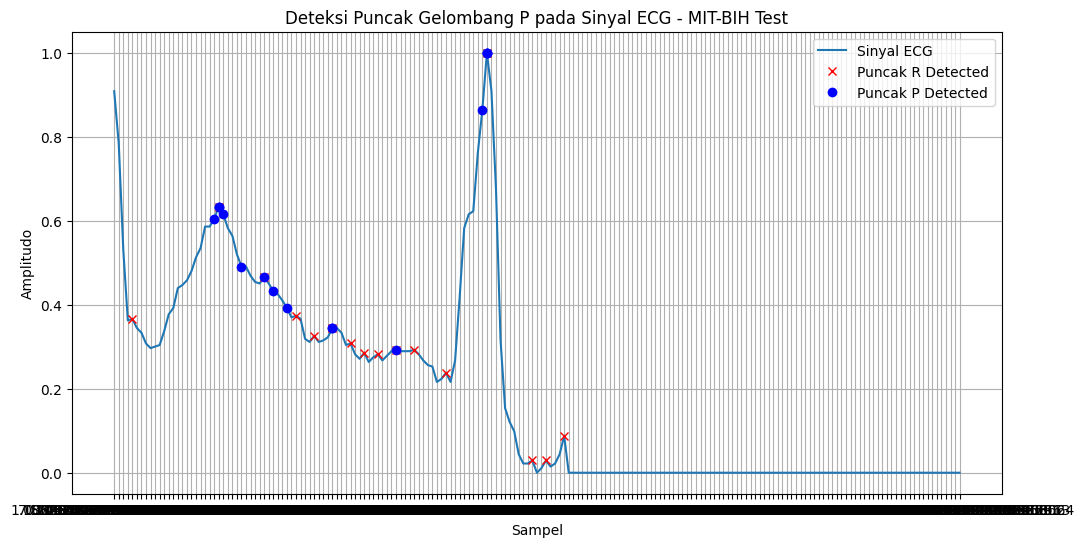

Dataset: MIT-BIH Test
Jumlah gelombang P yang terdeteksi: 15
Durasi Gelombang P (dalam detik): [np.float64(-0.144), np.float64(0.0), np.float64(0.08), np.float64(0.128), np.float64(0.128), np.float64(0.12), np.float64(0.136), np.float64(0.136), np.float64(0.08), np.float64(0.112), np.float64(0.032), np.float64(-0.064), np.float64(0.0), np.float64(0.08), np.float64(0.104)]



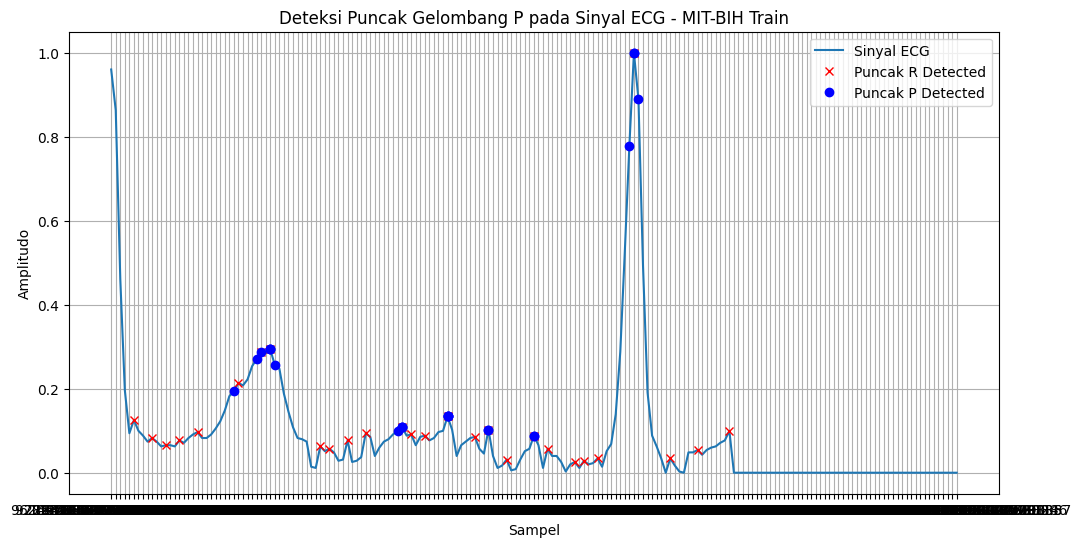

Dataset: MIT-BIH Train
Jumlah gelombang P yang terdeteksi: 23
Durasi Gelombang P (dalam detik): [np.float64(-0.176), np.float64(-0.184), np.float64(-0.168), np.float64(-0.16), np.float64(-0.128), np.float64(-0.056), np.float64(-0.024), np.float64(-0.224), np.float64(-0.144), np.float64(-0.128), np.float64(-0.096), np.float64(-0.144), np.float64(-0.08), np.float64(-0.064), np.float64(-0.04), np.float64(-0.072), np.float64(-0.024), np.float64(-0.08), np.float64(-0.048), np.float64(-0.168), np.float64(-0.152), np.float64(-0.104), np.float64(-0.096)]



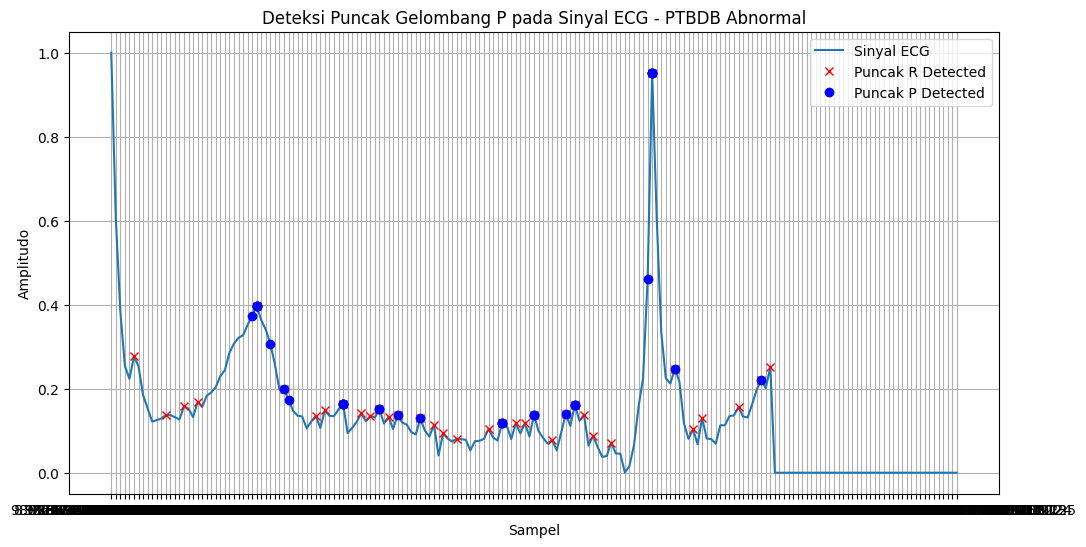

Dataset: PTBDB Abnormal
Jumlah gelombang P yang terdeteksi: 32
Durasi Gelombang P (dalam detik): [np.float64(-0.208), np.float64(-0.16), np.float64(-0.128), np.float64(-0.104), np.float64(0.0), np.float64(0.024), np.float64(0.056), np.float64(0.064), np.float64(0.0), np.float64(0.032), np.float64(0.048), np.float64(0.064), np.float64(0.016), np.float64(0.032), np.float64(0.04), np.float64(0.024), np.float64(-0.104), np.float64(-0.08), np.float64(-0.024), np.float64(-0.056), np.float64(-0.032), np.float64(-0.072), np.float64(-0.072), np.float64(-0.04), np.float64(-0.016), np.float64(-0.128), np.float64(-0.12), np.float64(-0.104), np.float64(-0.072), np.float64(0.0), np.float64(0.0), np.float64(-0.12)]



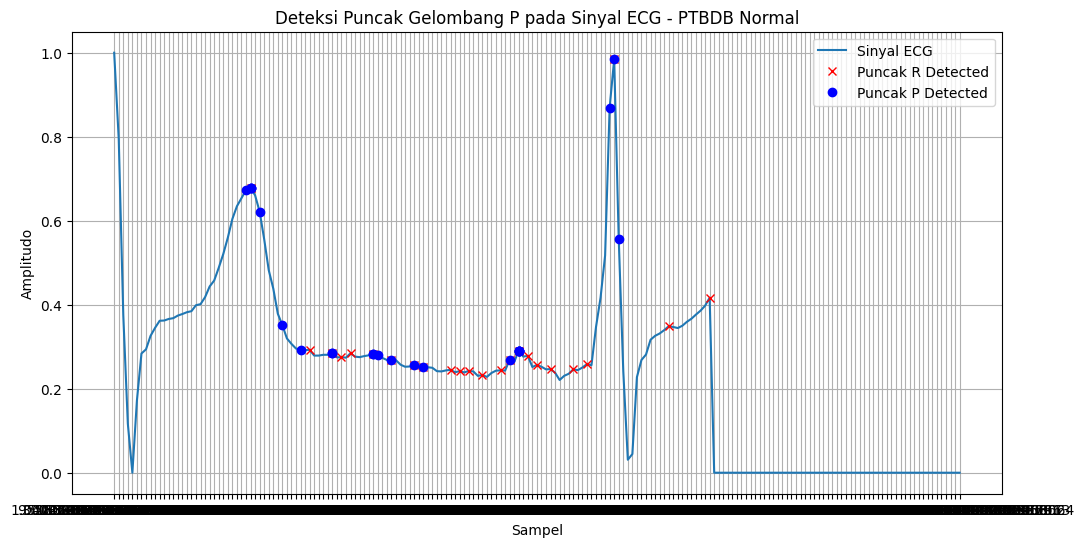

Dataset: PTBDB Normal
Jumlah gelombang P yang terdeteksi: 24
Durasi Gelombang P (dalam detik): [np.float64(0.008), np.float64(0.104), np.float64(0.144), np.float64(0.16), np.float64(0.16), np.float64(0.16), np.float64(0.16), np.float64(0.144), np.float64(0.16), np.float64(0.136), np.float64(0.152), np.float64(0.16), np.float64(0.16), np.float64(0.152), np.float64(0.152), np.float64(0.016), np.float64(0.016), np.float64(0.032), np.float64(0.056), np.float64(0.096), np.float64(0.12), np.float64(0.008), np.float64(0.096), np.float64(0.16)]



In [156]:
def extract_p_wave_duration(signal):
    peaks_r, _ = find_peaks(signal, height=0)

    p_peaks = []

    for r_peak in peaks_r:
        if r_peak > 20:
            p_peak = np.argmax(signal[r_peak-20:r_peak]) + (r_peak - 20)
            p_peaks.append(p_peak)

    p_durations = []
    for p_peak, r_peak in zip(p_peaks, peaks_r):
        p_duration = (r_peak - p_peak) / 125
        p_durations.append(p_duration)

    return p_durations

for name, dataset in datasets.items():
    signal = dataset.iloc[0, :-1]
    p_durations = extract_p_wave_duration(signal)

    plt.figure(figsize=(12, 6))
    plt.plot(signal, label='Sinyal ECG')
    peaks_r, _ = find_peaks(signal, height=0)
    plt.plot(peaks_r, signal[peaks_r], "x", label='Puncak R Detected', color='red')
    p_peaks = [np.argmax(signal[r-20:r]) + (r - 20) for r in peaks_r if r > 20]
    plt.plot(p_peaks, signal[p_peaks], "o", label='Puncak P Detected', color='blue')
    plt.title(f'Deteksi Puncak Gelombang P pada Sinyal ECG - {name}')
    plt.xlabel('Sampel')
    plt.ylabel('Amplitudo')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Dataset: {name}")
    print(f"Jumlah gelombang P yang terdeteksi: {len(p_durations)}")
    print(f"Durasi Gelombang P (dalam detik): {p_durations}\n")

<ipython-input-157-74275e5ed5fa>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_amplitudes = [signal[t_peak] for t_peak in t_peaks]
<ipython-input-157-74275e5ed5fa>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(peaks_r, signal[peaks_r], "x", label='R-peaks Detected', color='red')
<ipython-input-157-74275e5ed5fa>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(t_peaks, signal[t_peaks], "o", label='T-peaks

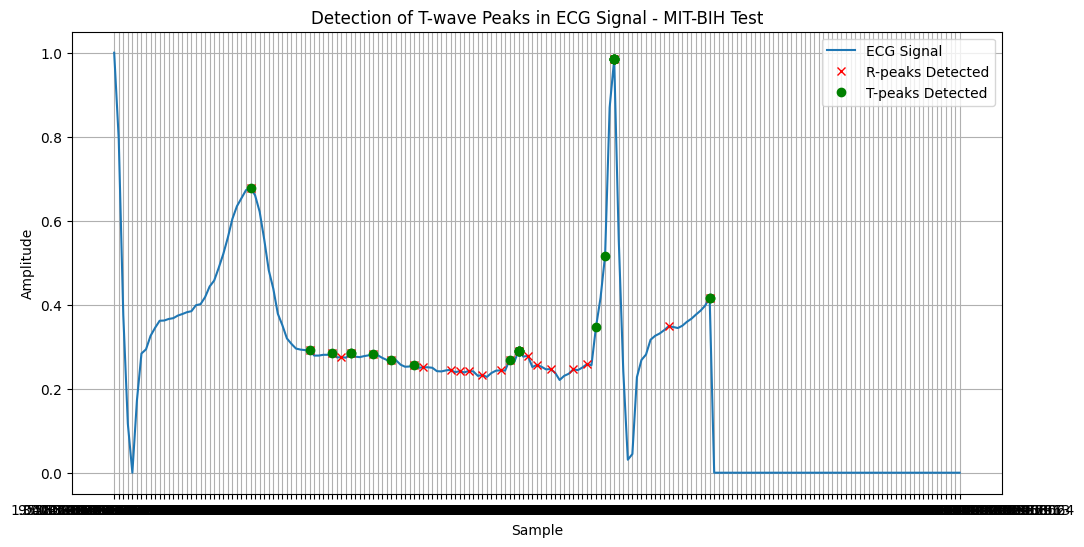

Dataset: MIT-BIH Test
Number of T-waves detected: 24
T-wave Durations (in seconds): [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.016), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.152), np.float64(0.12), np.float64(0.104), np.float64(0.088), np.float64(0.064), np.float64(0.032), np.float64(0.152), np.float64(0.152), np.float64(0.152), np.float64(0.136), np.float64(0.112), np.float64(0.072), np.float64(0.048), np.float64(0.0), np.float64(0.072), np.float64(0.0)]
T-wave Amplitudes: [np.float64(0.6784168481826782), np.float64(0.29251700639724726), np.float64(0.2857142984867096), np.float64(0.2844774127006531), np.float64(0.2844774127006531), np.float64(0.2826221287250519), np.float64(0.26901668310165405), np.float64(0.2572665512561798), np.float64(0.26901668310165405), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np

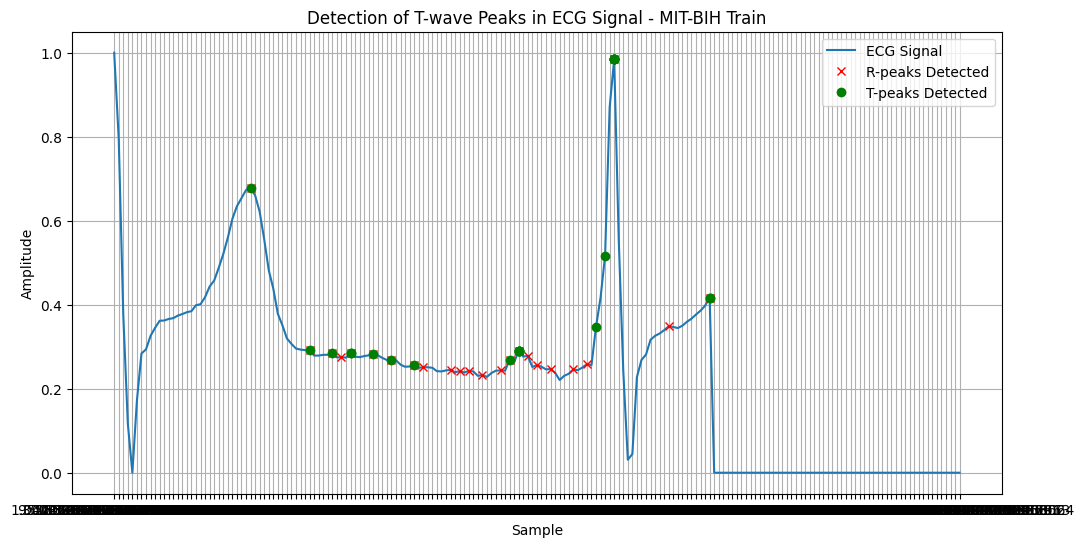

Dataset: MIT-BIH Train
Number of T-waves detected: 24
T-wave Durations (in seconds): [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.016), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.152), np.float64(0.12), np.float64(0.104), np.float64(0.088), np.float64(0.064), np.float64(0.032), np.float64(0.152), np.float64(0.152), np.float64(0.152), np.float64(0.136), np.float64(0.112), np.float64(0.072), np.float64(0.048), np.float64(0.0), np.float64(0.072), np.float64(0.0)]
T-wave Amplitudes: [np.float64(0.6784168481826782), np.float64(0.29251700639724726), np.float64(0.2857142984867096), np.float64(0.2844774127006531), np.float64(0.2844774127006531), np.float64(0.2826221287250519), np.float64(0.26901668310165405), np.float64(0.2572665512561798), np.float64(0.26901668310165405), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), n

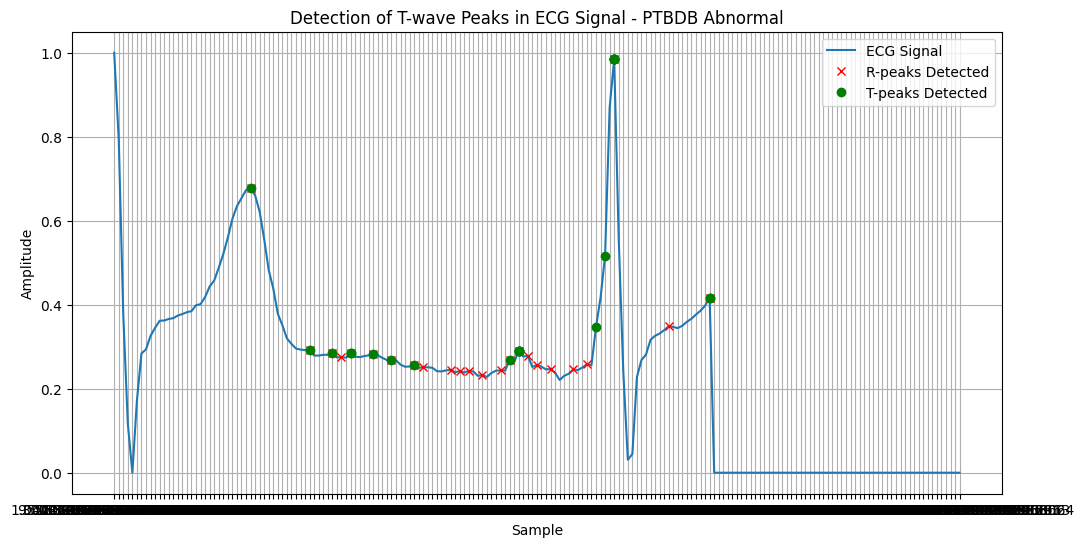

Dataset: PTBDB Abnormal
Number of T-waves detected: 24
T-wave Durations (in seconds): [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.016), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.152), np.float64(0.12), np.float64(0.104), np.float64(0.088), np.float64(0.064), np.float64(0.032), np.float64(0.152), np.float64(0.152), np.float64(0.152), np.float64(0.136), np.float64(0.112), np.float64(0.072), np.float64(0.048), np.float64(0.0), np.float64(0.072), np.float64(0.0)]
T-wave Amplitudes: [np.float64(0.6784168481826782), np.float64(0.29251700639724726), np.float64(0.2857142984867096), np.float64(0.2844774127006531), np.float64(0.2844774127006531), np.float64(0.2826221287250519), np.float64(0.26901668310165405), np.float64(0.2572665512561798), np.float64(0.26901668310165405), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), 

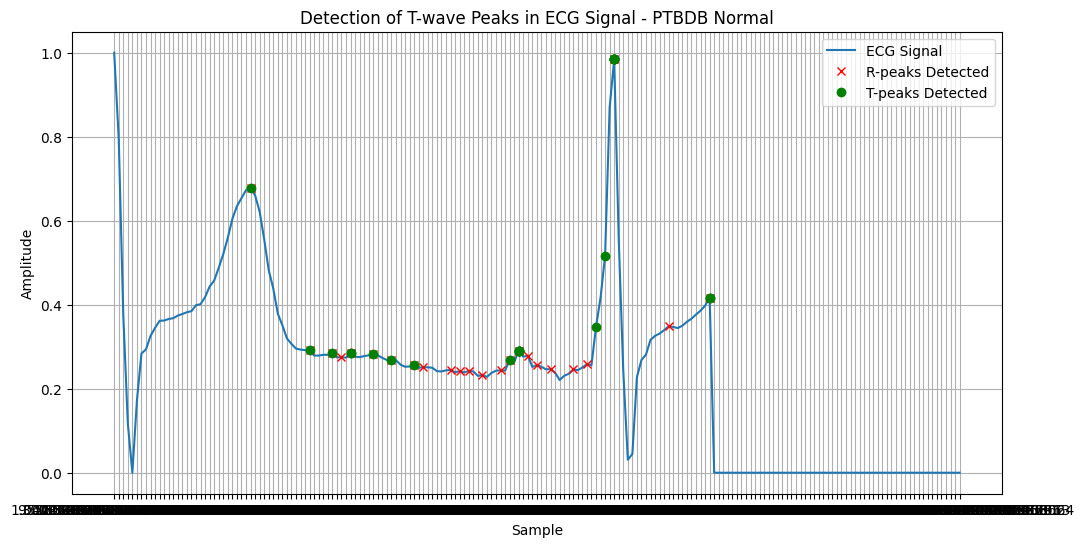

Dataset: PTBDB Normal
Number of T-waves detected: 24
T-wave Durations (in seconds): [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.016), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.152), np.float64(0.12), np.float64(0.104), np.float64(0.088), np.float64(0.064), np.float64(0.032), np.float64(0.152), np.float64(0.152), np.float64(0.152), np.float64(0.136), np.float64(0.112), np.float64(0.072), np.float64(0.048), np.float64(0.0), np.float64(0.072), np.float64(0.0)]
T-wave Amplitudes: [np.float64(0.6784168481826782), np.float64(0.29251700639724726), np.float64(0.2857142984867096), np.float64(0.2844774127006531), np.float64(0.2844774127006531), np.float64(0.2826221287250519), np.float64(0.26901668310165405), np.float64(0.2572665512561798), np.float64(0.26901668310165405), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np.float64(0.29066172242164606), np

In [157]:
def extract_t_wave(signal):
    peaks_r, _ = find_peaks(signal, height=0)

    t_peaks = []
    t_durations = []

    for r_peak in peaks_r:
        if r_peak < len(signal) - 20:
            t_peak = np.argmax(signal[r_peak:r_peak + 20]) + r_peak
            t_peaks.append(t_peak)

            t_duration = (t_peak - r_peak) / 125
            t_durations.append(t_duration)

    return t_peaks, t_durations

for name, dataset in datasets.items():
    t_peaks, t_durations = extract_t_wave(signal)

    t_amplitudes = [signal[t_peak] for t_peak in t_peaks]

    plt.figure(figsize=(12, 6))
    plt.plot(signal, label='ECG Signal')
    plt.plot(peaks_r, signal[peaks_r], "x", label='R-peaks Detected', color='red')
    plt.plot(t_peaks, signal[t_peaks], "o", label='T-peaks Detected', color='green')
    plt.title(f'Detection of T-wave Peaks in ECG Signal - {name}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Dataset: {name}")
    print(f"Number of T-waves detected: {len(t_durations)}")
    print(f"T-wave Durations (in seconds): {t_durations}")
    print(f"T-wave Amplitudes: {t_amplitudes}\n")




In [158]:
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def plot_time_domain(data, title, signal_index):
    plt.figure(figsize=(10, 4))
    plt.plot(data.iloc[signal_index, :-1], label=title)
    plt.title(f'{title} - Domain Waktu (Sinyal {signal_index + 1})')
    plt.xlabel('Sampel')
    plt.ylabel('Amplitudo')
    plt.legend()
    plt.grid()
    plt.show()

def plot_frequency_domain(data, title, signal_index, fs):
    signal = data.iloc[signal_index, :-1]
    signal = pd.to_numeric(signal, errors='coerce').fillna(0)
    fft_result = fft(signal)
    freq = fftfreq(len(signal), d=1/fs)

    plt.figure(figsize=(10, 4))
    plt.plot(freq[:len(freq)//2], abs(fft_result[:len(freq)//2]), label=title)
    plt.title(f'{title} - Domain Frekuensi (Sinyal {signal_index + 1})')
    plt.xlabel('Frekuensi (Hz)')
    plt.ylabel('Magnitudo')
    plt.legend()
    plt.grid()
    plt.show()

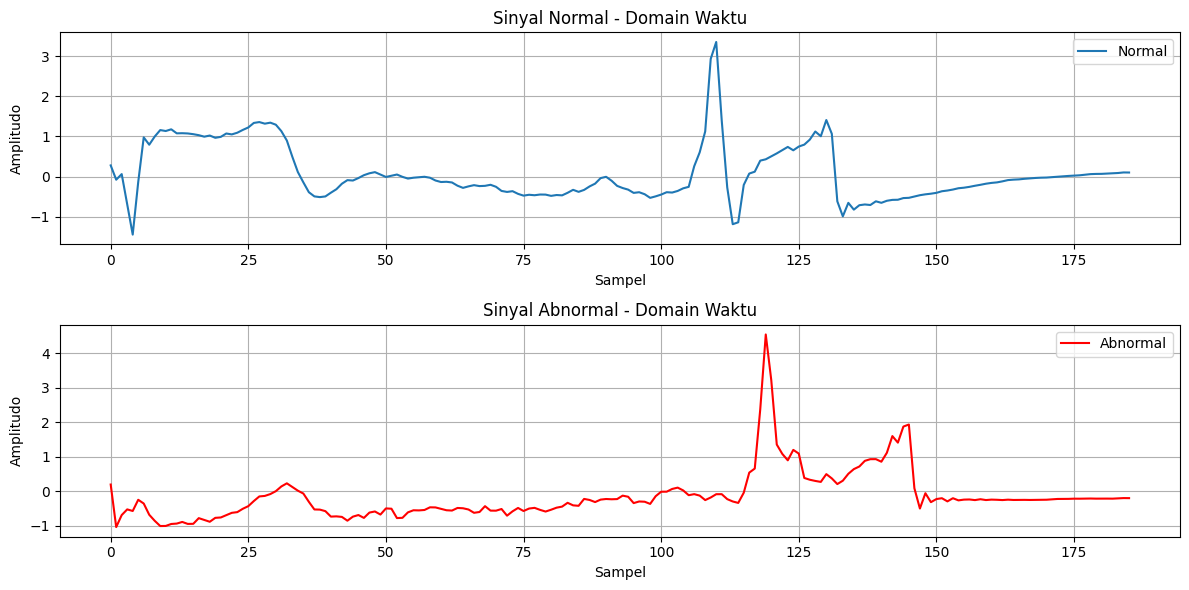

In [159]:
fs = 125
lowcut = 0.5
highcut = 50

normal_signal = bandpass_filter(ptbdb_normal_normalized_z_score.iloc[0, :-1], lowcut, highcut, fs)
abnormal_signal = bandpass_filter(ptbdb_abnormal_normalized_z_score.iloc[0, :-1], lowcut, highcut, fs)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(normal_signal, label='Normal')
plt.title('Sinyal Normal - Domain Waktu')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(abnormal_signal, label='Abnormal', color='r')
plt.title('Sinyal Abnormal - Domain Waktu')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


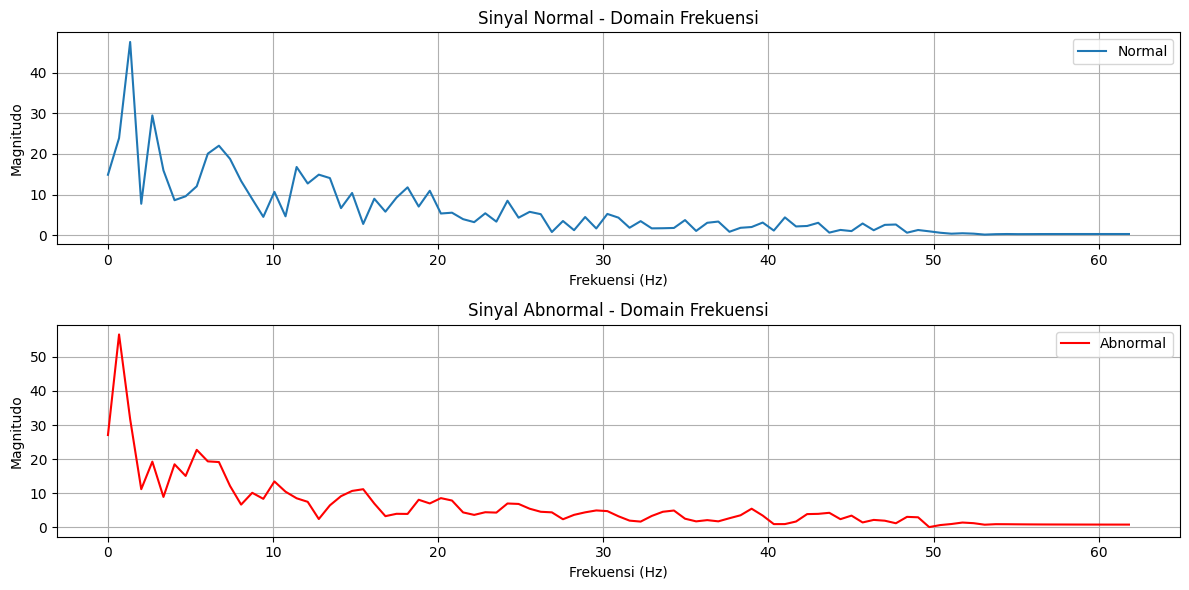

In [160]:
normal_fft = fft(normal_signal)
abnormal_fft = fft(abnormal_signal)
freq = fftfreq(len(normal_signal), d=1/fs)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(freq[:len(freq)//2], abs(normal_fft[:len(normal_fft)//2]), label='Normal')
plt.title('Sinyal Normal - Domain Frekuensi')
plt.xlabel('Frekuensi (Hz)')
plt.ylabel('Magnitudo')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freq[:len(freq)//2], abs(abnormal_fft[:len(abnormal_fft)//2]), label='Abnormal', color='r')
plt.title('Sinyal Abnormal - Domain Frekuensi')
plt.xlabel('Frekuensi (Hz)')
plt.ylabel('Magnitudo')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [161]:
def calculate_snr(signal, noise):
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    if noise_power == 0:
        return float('inf')
    return 10 * np.log10(signal_power / noise_power)

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

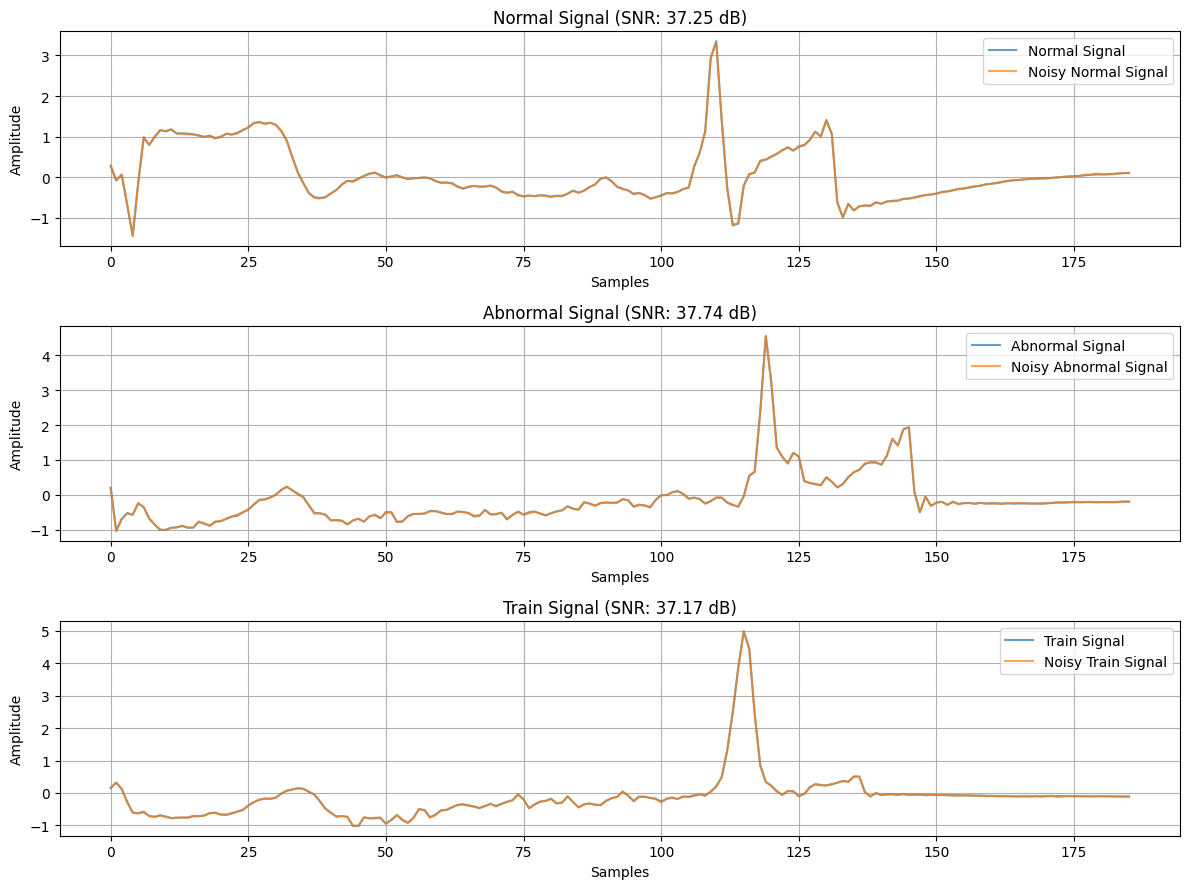

In [162]:
signal_index = 0
normal_signal = ptbdb_normal_normalized_z_score.iloc[signal_index, :-1].values
abnormal_signal = ptbdb_abnormal_normalized_z_score.iloc[signal_index, :-1].values
train_signal = mitbih_train_normalized_z_score.iloc[signal_index, :-1].values

filtered_normal_signal = bandpass_filter(normal_signal, lowcut, highcut, fs)
filtered_abnormal_signal = bandpass_filter(abnormal_signal, lowcut, highcut, fs)
filtered_train_signal = bandpass_filter(train_signal, lowcut, highcut, fs)

np.random.seed(42)
noise_level = 0.01
normal_noise = np.random.normal(0, noise_level, len(filtered_normal_signal))
abnormal_noise = np.random.normal(0, noise_level, len(filtered_abnormal_signal))
train_noise = np.random.normal(0, noise_level, len(filtered_train_signal))

noisy_normal_signal = filtered_normal_signal + normal_noise
noisy_abnormal_signal = filtered_abnormal_signal + abnormal_noise
noisy_train_signal = filtered_train_signal + train_noise

snr_normal = calculate_snr(filtered_normal_signal, normal_noise)
snr_abnormal = calculate_snr(filtered_abnormal_signal, abnormal_noise)
snr_train = calculate_snr(filtered_train_signal, train_noise)

plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.plot(filtered_normal_signal, label='Normal Signal', alpha=0.7)
plt.plot(noisy_normal_signal, label='Noisy Normal Signal', alpha=0.7)
plt.title(f'Normal Signal (SNR: {snr_normal:.2f} dB)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(filtered_abnormal_signal, label='Abnormal Signal', alpha=0.7)
plt.plot(noisy_abnormal_signal, label='Noisy Abnormal Signal', alpha=0.7)
plt.title(f'Abnormal Signal (SNR: {snr_abnormal:.2f} dB)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(filtered_train_signal, label='Train Signal', alpha=0.7)
plt.plot(noisy_train_signal, label='Noisy Train Signal', alpha=0.7)
plt.title(f'Train Signal (SNR: {snr_train:.2f} dB)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


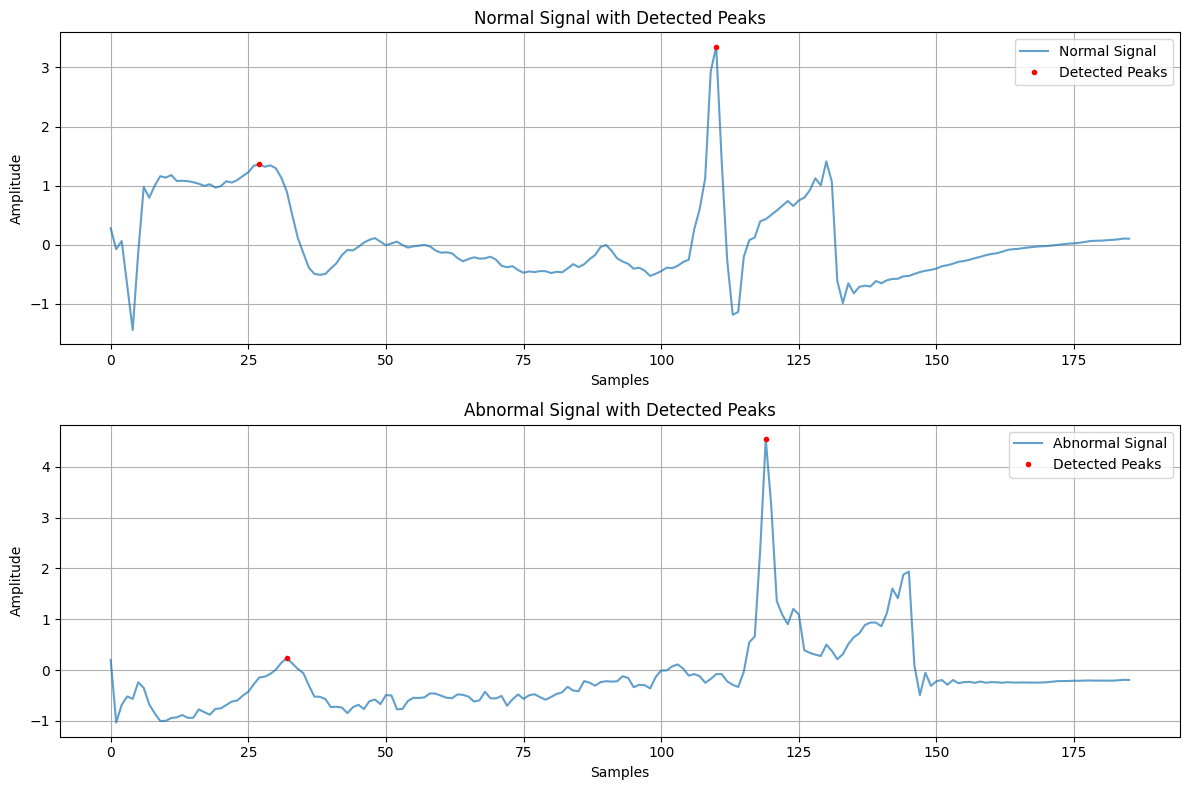

RR Intervals (Normal): [0.664]
Mean RR Interval (Normal): 0.664
RR Intervals (Abnormal): [0.696]
Mean RR Interval (Abnormal): 0.696


In [163]:
def identify_rr_intervals(signal, fs):
    peaks, _ = find_peaks(signal, distance=fs*0.6)
    rr_intervals = np.diff(peaks) / fs
    return rr_intervals, peaks

normal_rr_intervals, normal_peaks = identify_rr_intervals(filtered_normal_signal, fs)
abnormal_rr_intervals, abnormal_peaks = identify_rr_intervals(filtered_abnormal_signal, fs)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(filtered_normal_signal, label='Normal Signal', alpha=0.7)
plt.plot(normal_peaks, filtered_normal_signal[normal_peaks], 'r.', label='Detected Peaks')
plt.title('Normal Signal with Detected Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(filtered_abnormal_signal, label='Abnormal Signal', alpha=0.7)
plt.plot(abnormal_peaks, filtered_abnormal_signal[abnormal_peaks], 'r.', label='Detected Peaks')
plt.title('Abnormal Signal with Detected Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

print("RR Intervals (Normal):", normal_rr_intervals)
print("Mean RR Interval (Normal):", np.mean(normal_rr_intervals))
print("RR Intervals (Abnormal):", abnormal_rr_intervals)
print("Mean RR Interval (Abnormal):", np.mean(abnormal_rr_intervals))